In [21]:
import sys
import os
from itertools import product
import math
import numpy
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE, MDS
import umap
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

sys.path.append(os.path.abspath("../"))
from distances import *

In [22]:
def symmetrize(A):
    n = A.shape[0]
    B = A.copy()
    B[np.tril_indices(n)] = B.T[np.tril_indices(n)]
    return B

In [23]:
all_classes = {}

all_classes["resnet"] = ['regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf',
            'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf',
            'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet18',
            'resnext50_32x4d', 'wide_resnet50_2'] # convolutional residual networks (skip connections)

all_classes["efficientnet"] = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4',
            'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7'] # convolutional

all_classes["alexnet"] = ["alexnet"] # convolutional

all_classes["googlenet"] = ["googlenet"] # convolutional

all_classes["inception"] = ["inception"] # convolutional

all_classes["mnasnet"] = ["mnasnet"] # convolutional

all_classes["densenet"] = ["densenet"] # convolutional with all-to-all skip connection (so also residual)

all_classes["shufflenet"] = ["shufflenet"] # convolutional

all_classes["squeezenet"] = ["squeezenet"] # convolutional

all_classes["vgg16"] = ["vgg16"] # convolutional

all_classes["mobilenet"] = ['mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small'] # convolutional

all_classes["convnext"] = ['convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny'] # depthwise convolutional that were designed to compete with transformers

all_classes["vit"] = ['vit_b_16', 'vit_b_32', 'vit_l_16', 'vit_l_32'] # vision transformers


classes = {}
for c in all_classes:
    if len(all_classes[c]) > 1:
        classes[c] = all_classes[c]
num_classes = len(classes)
class_names = np.array(list(classes.keys()))

In [24]:
len(classes['resnet'])

17

In [25]:
subset = "train"
n = 10000

In [6]:
#pretrained = False
#mode = "eval"

#untrained_reps = []
#pretrained_reps = []
#reps_folder = f"reps/{subset}/{n}_{mode}"
#filenames = os.listdir(reps_folder)
#for filename in filenames:
#    if "pretrained" in filename:
#        pretrained_reps.append(filename[:-4])
#    elif "untrained" in filename:
#        untrained_reps.append(filename[:-4])
#untrained_reps = np.sort(untrained_reps)
#pretrained_reps = np.sort(pretrained_reps)

#model_names = untrained_reps
#folder = f"distances/{subset}/untrained"
#if pretrained:
#    model_names = pretrained_reps
#    folder = f"distances/{subset}/pretrained"
#total_models = len(model_names)

In [26]:
model_names = np.sort([x[:-4] for x in os.listdir("models")])
pretrained_model_names = []
untrained_model_names = []
for name in model_names:
    if "pretrained" in name:
        pretrained_model_names.append(name)
    elif "untrained" in name:
        untrained_model_names.append(name)

pretrained_model_names = np.array(pretrained_model_names)
num_pretrained_models = len(pretrained_model_names)
untrained_model_names = np.array(untrained_model_names)
num_untrained_models = len(untrained_model_names)

In [8]:
short_untrained_model_names = np.array(["_".join(name.split("_")[:-1]) for name in untrained_model_names])
short_pretrained_model_names = np.array(["_".join(name.split("_")[:-1]) for name in pretrained_model_names])

In [9]:
#filenames = os.listdir(f"distances/{subset}/untrained/")
#distnames = []
#for filename in filenames:
#    if filename.endswith("npy"):
#        distnames.append(filename[:-4])
#distnames = np.sort(distnames)

In [9]:
distnames = np.array(['lin_cka_dist',
             'lin_cka_prime_dist',
             'mean_cca_e2e',
             'mean_sq_cca_e2e',
             'procrustes',
             'pwcca_dist_e2e',
             'predictor_dist_0.0',
             'predictor_dist_1e-20',
             'predictor_dist_1e-19',
             'predictor_dist_1e-18',
             'predictor_dist_1e-17',
             'predictor_dist_1e-16',
             'predictor_dist_1e-15',
             'predictor_dist_1e-14',
             'predictor_dist_1e-13',
             'predictor_dist_1e-12',
             'predictor_dist_1e-11',
             'predictor_dist_1e-10',
             'predictor_dist_1e-09',
             'predictor_dist_1e-08',
             'predictor_dist_1e-07',
             'predictor_dist_1e-06',
             'predictor_dist_1e-05',
             'predictor_dist_0.0001',
             'predictor_dist_0.001',
             'predictor_dist_0.01',
             'predictor_dist_0.1',
             'predictor_dist_1.0',
             'predictor_dist_10.0',
             'predictor_dist_100.0',
             'predictor_dist_1000.0',
             'predictor_dist_10000.0'])

In [10]:
stats = np.load(f"distances/{subset}/untrained/stats.npz")
#model_names = stats["model_names"]
#if pretrained:
#    model_names = np.array([x[:-15] for x in model_names])
#else:
#    model_names = np.array([x[:-4] for x in model_names])
#total_models = len(model_names)
dist_pairs_saved = stats["dist_pairs_saved"]

In [11]:
print(np.arange(num_untrained_models) - np.sum(dist_pairs_saved, axis=0))
print(np.arange(num_untrained_models) - np.flip(np.sum(dist_pairs_saved, axis=1)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [13]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), normalize])

train_dataset = torchvision.datasets.ImageFolder("/home/gridsan/groups/datasets/ImageNet/train/", transform=transform)
val_dataset = torchvision.datasets.ImageFolder("/home/gridsan/groups/datasets/ImageNet/val/", transform=transform)
print(len(train_dataset))
print(len(val_dataset))

1281119
49997


## Pretrained network embeddings plots

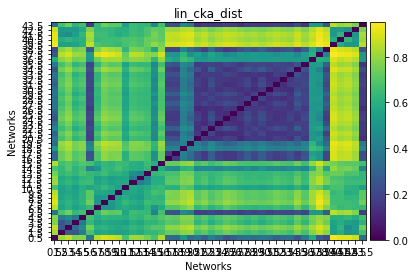

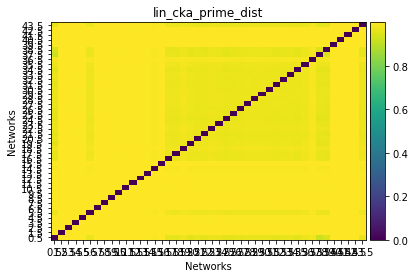

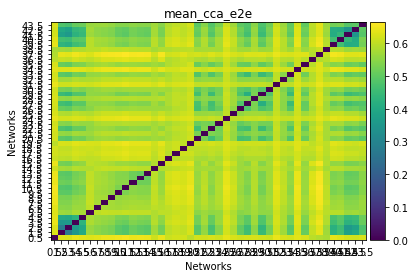

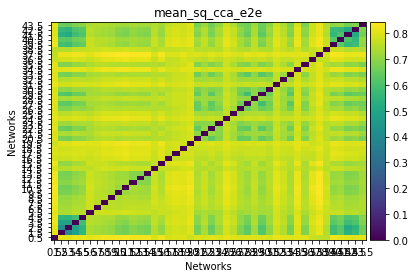

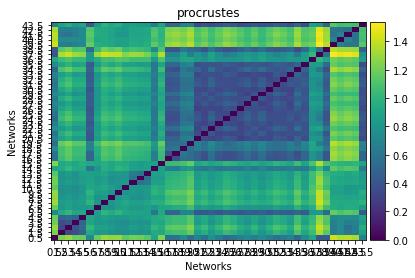

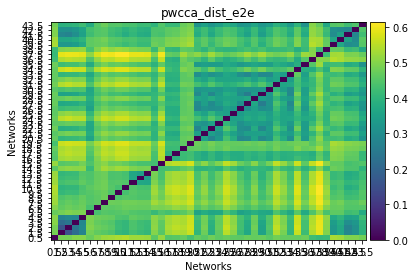

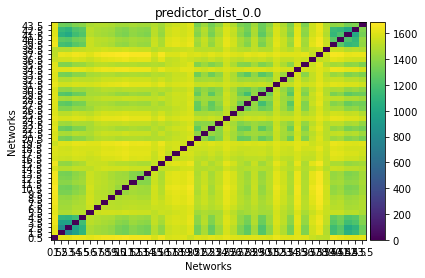

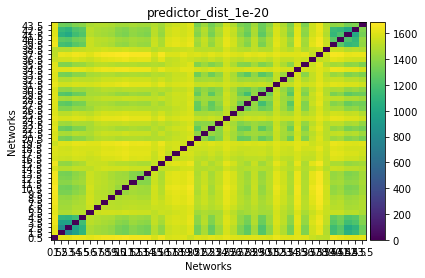

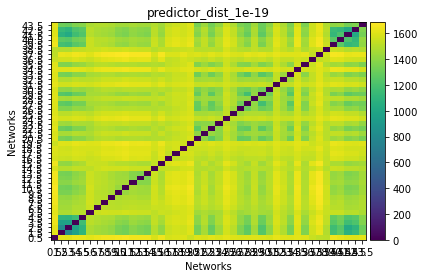

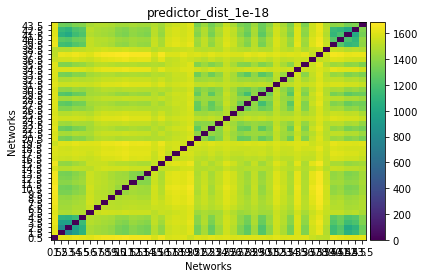

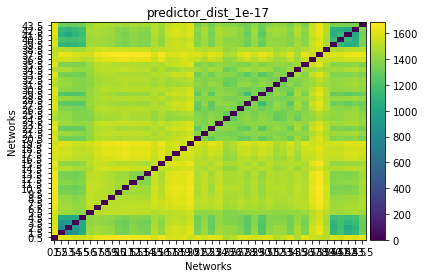

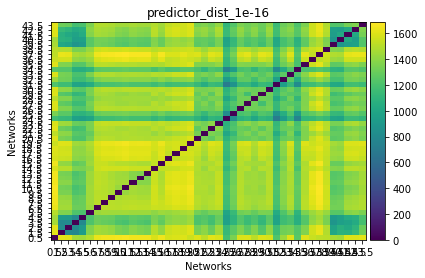

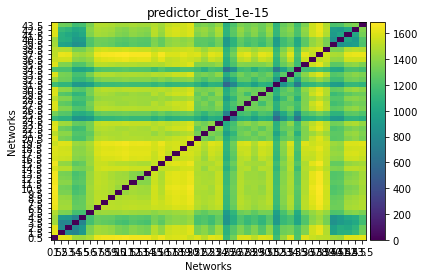

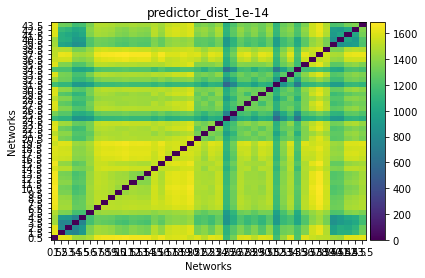

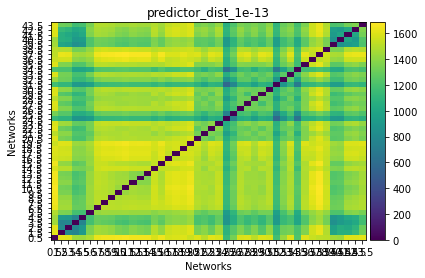

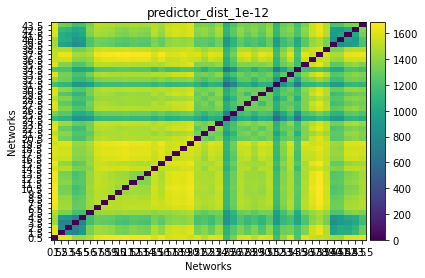

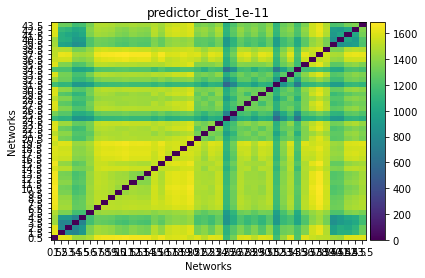

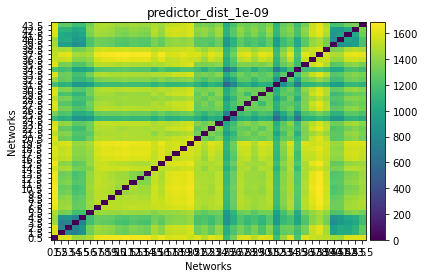

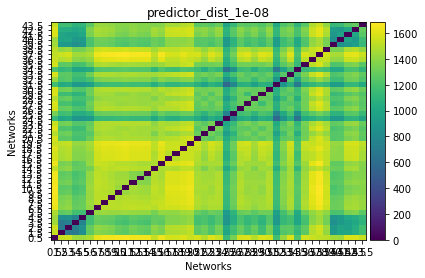

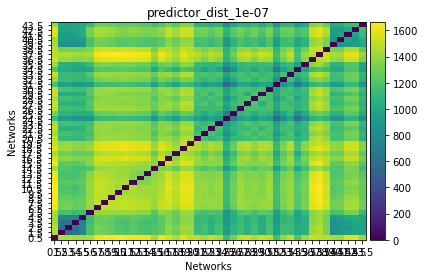

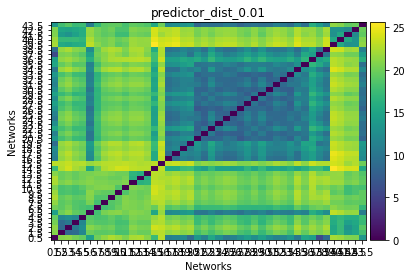

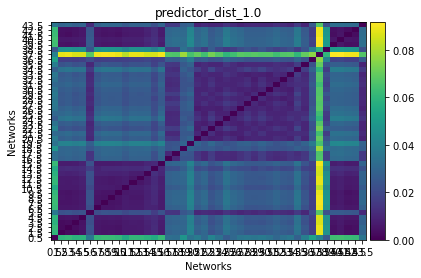

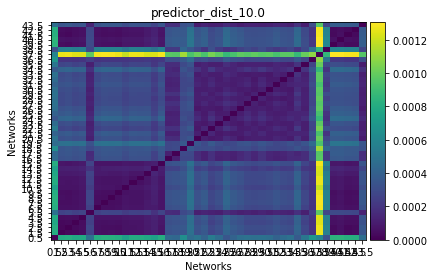

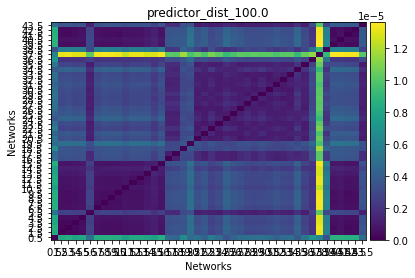

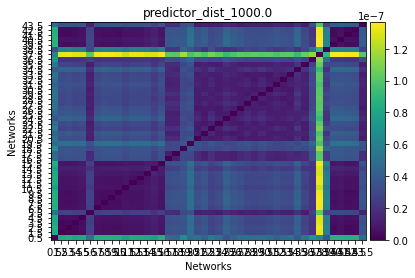

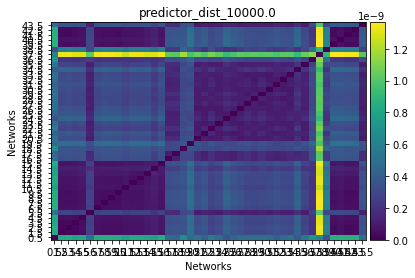

In [85]:
stats = np.load(f"distances/{subset}/pretrained/stats.npz")
stats_model_names = np.sort([x[:-4] for x in stats["model_names"]])
assert np.all(stats_model_names == pretrained_model_names)

short_model_names = np.array(["_".join(name.split("_")[:-1]) for name in pretrained_model_names])

for distname in distnames:
    D = np.load(f'distances/{subset}/pretrained/{distname}.npy')
    D = np.reshape(D, [num_pretrained_models, num_pretrained_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    
    #Z = linkage(pdist(D), 'ward')
    #fig, ax = plt.subplots()
    #dendrogram(Z, labels=pretrained_model_names, ax=ax)
    #ax.set_title("Dendogram")
    #plt.show()
    #sorted_inds = leaves_list(Z)
    
    fig, ax = plt.subplots()
    im = ax.pcolormesh(D)#[sorted_inds][:, sorted_inds])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title(distname)
    ax.set_yticks(np.arange(num_pretrained_models) + 0.5)
    #ax.set_yticklabels(pretrained_model_names[sorted_inds])
    ax.set_ylabel("Networks")
    ax.set_xticks(np.arange(num_pretrained_models) + 0.5)
    #ax.set_xticklabels(pretrained_model_names[sorted_inds], rotation=90)
    ax.set_xlabel("Networks")
    plt.show()

In [49]:
distname = "predictor_dist_0.01" #"procrustes"

D = np.load(f'distances/{subset}/pretrained/{distname}.npy')
D = np.reshape(D, [num_pretrained_models, num_pretrained_models])
D = symmetrize(D)
np.fill_diagonal(D, 0)

Z = linkage(pdist(D), 'ward')
sorted_inds = leaves_list(Z)

In [66]:
embed_type = "TSNE"

if embed_type == "TSNE":
    X_embedded = TSNE(n_components=2, perplexity=20.0, init="random", metric="precomputed").fit_transform(D)
elif embed_type == "UMAP":
    X_embedded = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1).fit_transform(np.sqrt(D))
elif embed_type == "MDS":
    X_embedded = MDS(n_components=2, dissimilarity="precomputed").fit_transform(np.sqrt(D))

padding = 0.1
xmin = np.min(X_embedded[:, 0])
xmax = np.max(X_embedded[:, 0])
xrange = xmax - xmin
xmin -= padding * xrange
xmax += padding * xrange
ymin = np.min(X_embedded[:, 1])
ymax = np.max(X_embedded[:, 1])
yrange = ymax - ymin
ymin -= padding * yrange
ymax += padding * yrange

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


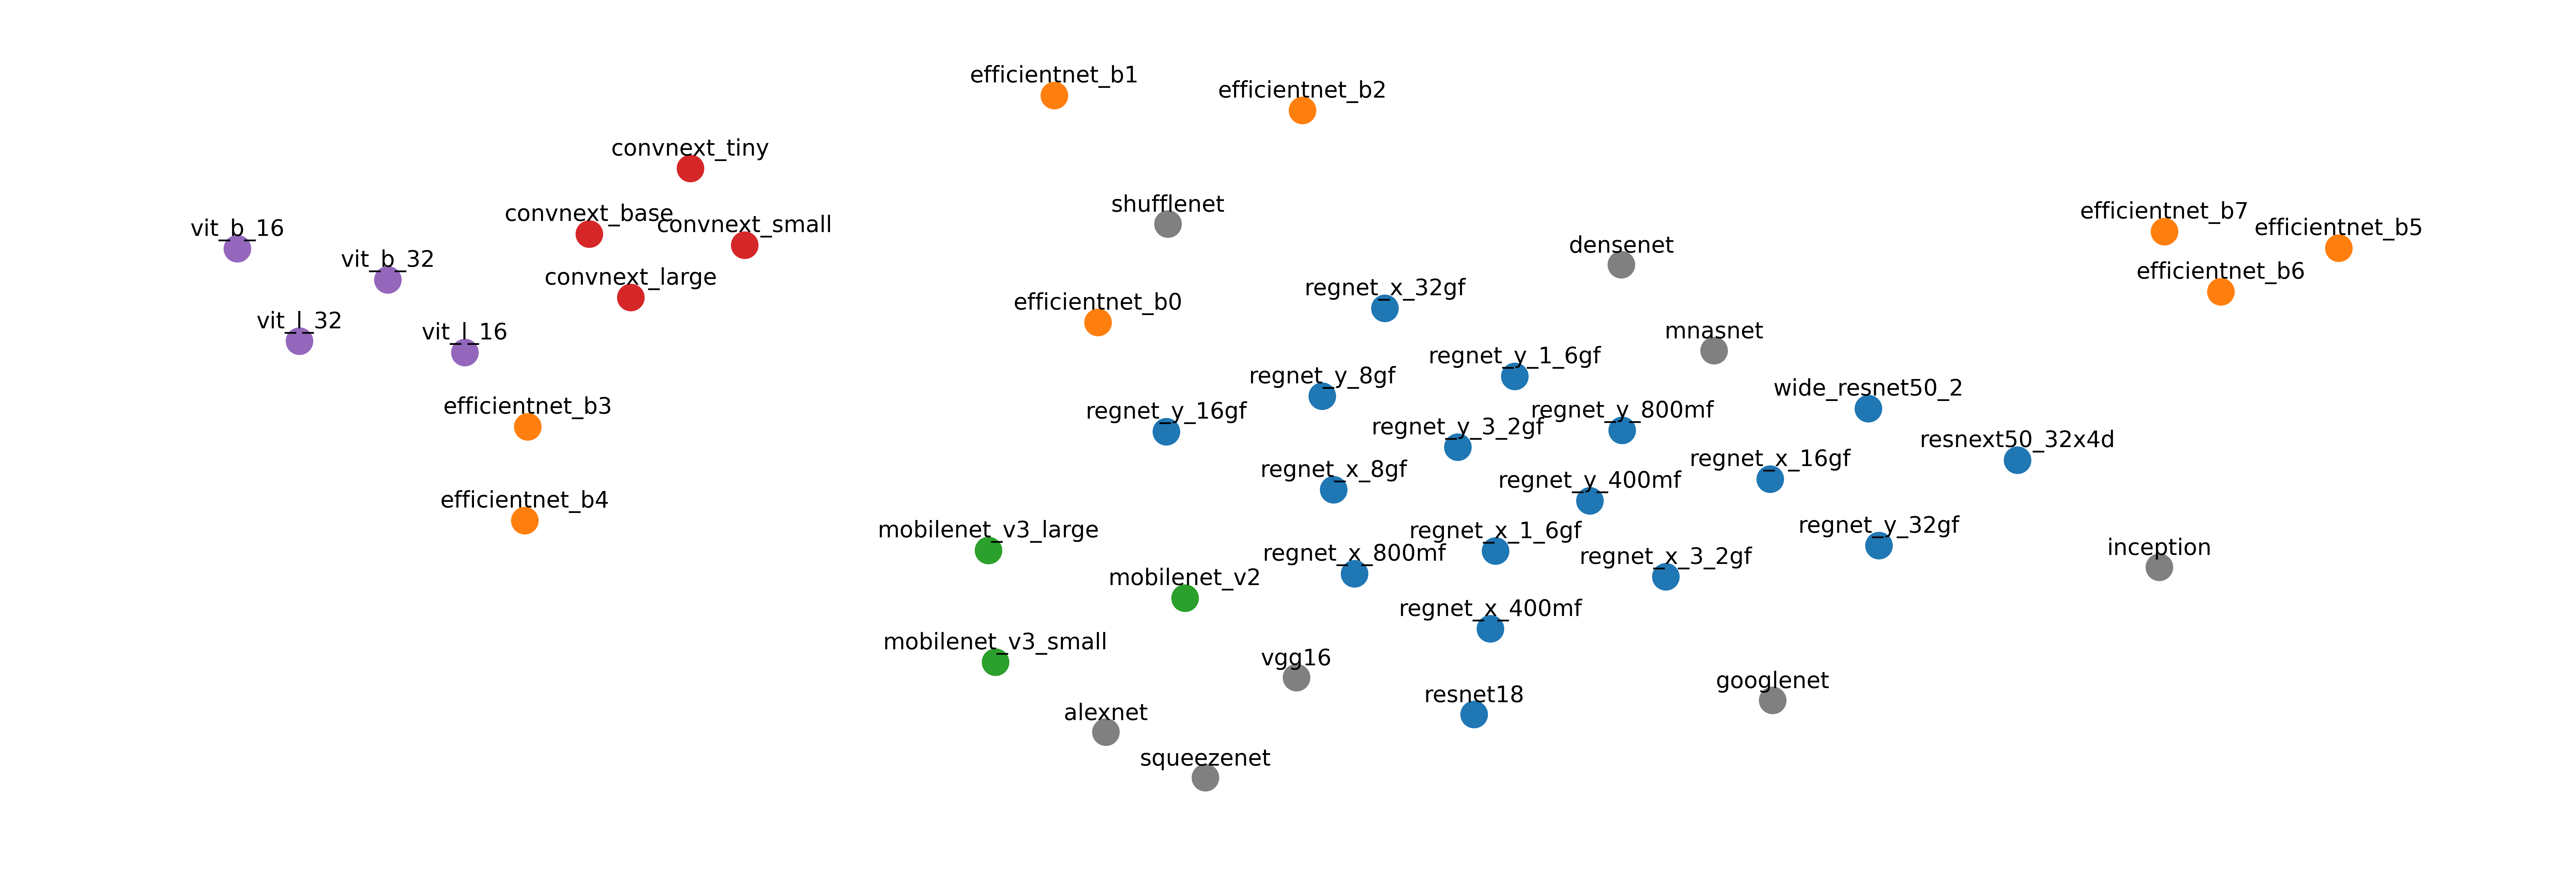

In [69]:
#fig, ax = plt.subplots()
# plot distance matrix ordered by hierarchical clustering
#im = ax.pcolormesh(D[sorted_inds][:, sorted_inds])
#divider = make_axes_locatable(ax)
#cax = divider.append_axes('right', size='5%', pad=0.05)
#fig.colorbar(im, cax=cax, orientation='vertical')
#ax.set_title(distname)
#ax.set_yticks(np.arange(num_pretrained_models) + 0.5)
#ax.set_yticklabels(pretrained_model_names[sorted_inds])
#ax.set_ylabel("Networks")
#ax.set_xticks(np.arange(num_pretrained_models) + 0.5)
#ax.set_xticklabels(pretrained_model_names[sorted_inds], rotation=90)
#ax.set_xlabel("Networks")
#plt.show()

# plot hierarchical clustering
#fig, ax = plt.subplots()
#dendrogram(Z, labels=pretrained_model_names, ax=ax)
#ax.set_title("Dendogram")
#plt.show()

# plot network embedding colored by major network groups
cmap = plt.cm.tab10
colors = [cmap(i) for i in range(num_classes)]

fig = plt.figure(dpi=1000, figsize=(12, 4))
ax = fig.add_subplot()#projection='3d')
other_inds = np.ones(len(short_pretrained_model_names), dtype=bool)
for i in range(num_classes):
    class_inds = np.in1d(short_pretrained_model_names, classes[class_names[i]])
    other_inds = other_inds & ~class_inds
    ax.scatter(X_embedded[class_inds, 0], X_embedded[class_inds, 1], s=40, color=colors[i])
ax.scatter(X_embedded[other_inds, 0], X_embedded[other_inds, 1], s=40, color="gray")
for i in range(num_pretrained_models):
    ax.text(X_embedded[i, 0], X_embedded[i, 1]+5, short_pretrained_model_names[i], fontsize=6, horizontalalignment="center", verticalalignment="bottom")
#plt.title(f"{embed_type} embedding for GULP λ = 1e-2")
#plt.legend(np.append(class_names, "other"))
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.view_init(30, 0)
#plt.savefig("/home/gridsan/gstepaniants/geometric_toolkit_shared/paper_figures/gulp_tsne_teaser.pdf", bbox_inches='tight')
plt.show()

# plot network embedding colored by individual network architecture
#cmap = plt.cm.viridis
#colors = [cmap(i/num_pretrained_models) for i in range(num_pretrained_models)]
#
#plt.figure(dpi=1000)
#for i in range(num_pretrained_models):
#    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], s=2, color=colors[i])
#    plt.text(X_embedded[i, 0], X_embedded[i, 1], short_model_names[i], fontsize=4, horizontalalignment="center", verticalalignment="bottom")
#plt.title(f"{embed_type} embedding for {distname}")
#plt.legend(short_model_names, fontsize=3)
#plt.xlim([xmin, xmax])
#plt.ylim([ymin, ymax])
#plt.show()

## Untrained network embedding plots

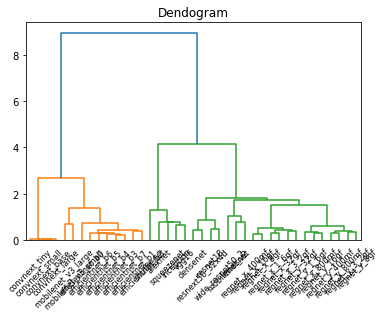

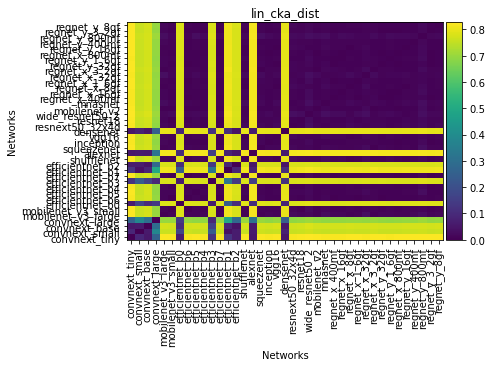

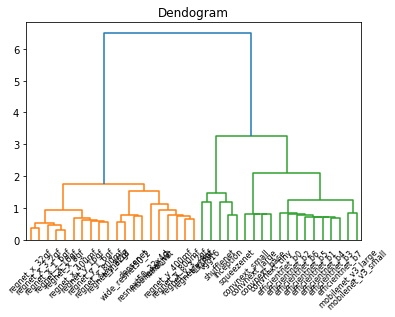

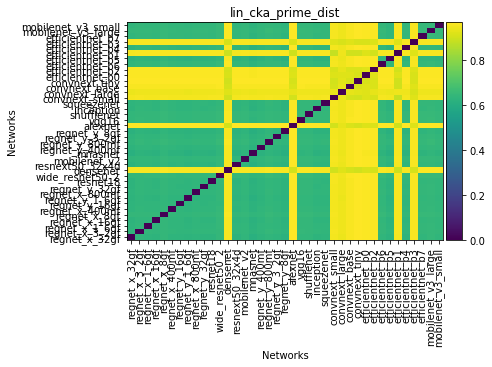

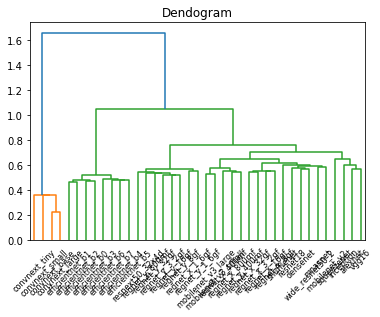

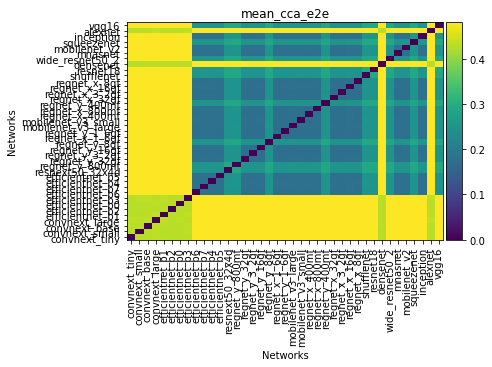

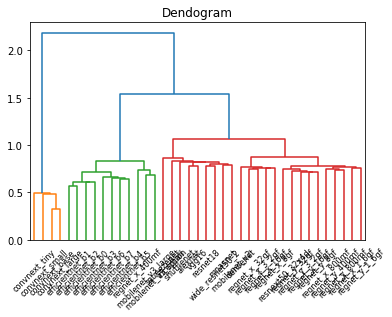

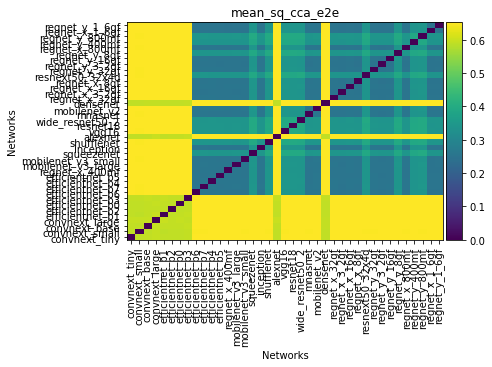

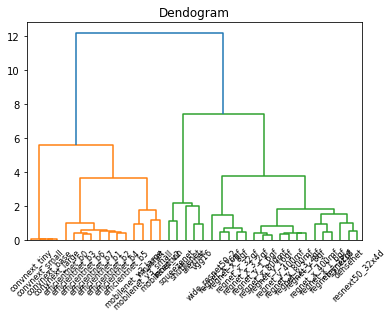

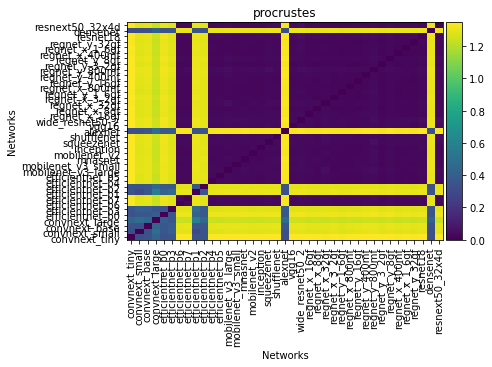

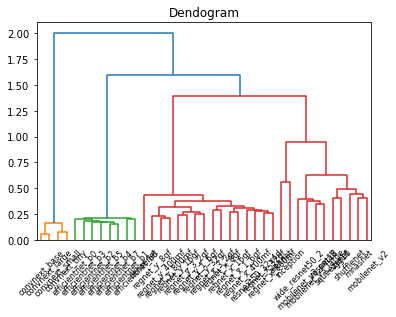

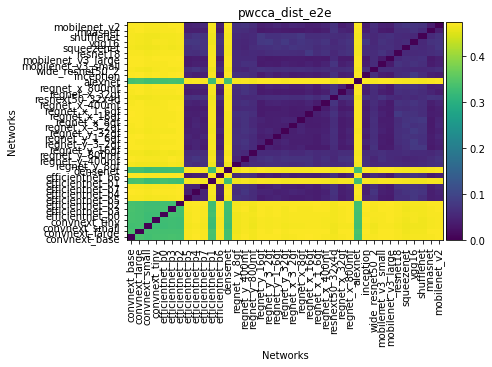

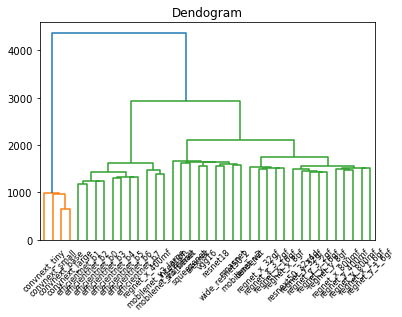

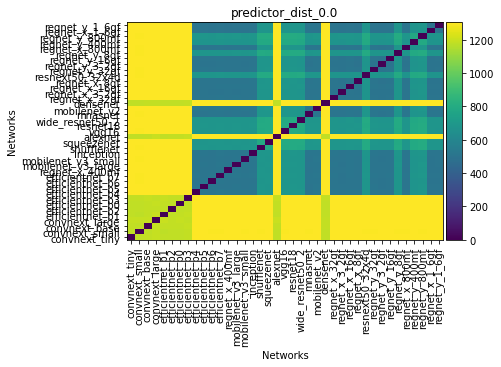

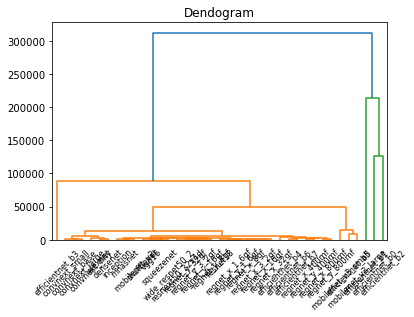


KeyboardInterrupt



In [29]:
stats = np.load(f"distances/{subset}/untrained/stats.npz")
stats_model_names = np.sort([x[:-4] for x in stats["model_names"]])
assert np.all(stats_model_names == untrained_model_names)

short_model_names = np.array(["_".join(name.split("_")[:-1]) for name in untrained_model_names])
unique_short_model_names = np.unique(short_model_names)
num_unique_models = len(unique_short_model_names)

for distname in distnames:
    D = np.load(f'distances/{subset}/untrained/{distname}.npy')
    D = np.reshape(D, [num_untrained_models, num_untrained_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    
    # take strided average of large distance matrix
    num_copies = 10
    num_nets = num_untrained_models // num_copies
    D_ave = np.zeros((num_nets, num_nets))
    for i in range(num_nets):
        for j in range(i, num_nets):
            for ii in range(num_copies):
                for jj in range(ii+1, num_copies):
                    D_ave[i, j] += D[num_copies*i+ii, num_copies*j+jj]
    D_ave /= num_copies*(num_copies)/2
    D_ave = symmetrize(D_ave)
    np.fill_diagonal(D_ave, 0)
    
    Z = linkage(pdist(D_ave), 'ward')
    fig, ax = plt.subplots()
    dendrogram(Z, labels=unique_short_model_names, ax=ax)
    ax.set_title("Dendogram")
    plt.show()
    sorted_inds = leaves_list(Z)
    
    fig, ax = plt.subplots()
    im = ax.pcolormesh(D[sorted_inds][:, sorted_inds])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title(distname)
    ax.set_yticks(np.arange(num_unique_models) + 0.5)
    ax.set_yticklabels(unique_short_model_names[sorted_inds])
    ax.set_ylabel("Networks")
    ax.set_xticks(np.arange(num_unique_models) + 0.5)
    ax.set_xticklabels(unique_short_model_names[sorted_inds], rotation=90)
    ax.set_xlabel("Networks")
    plt.show()

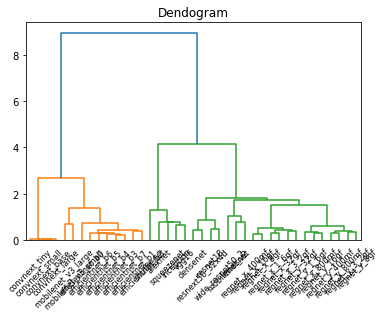

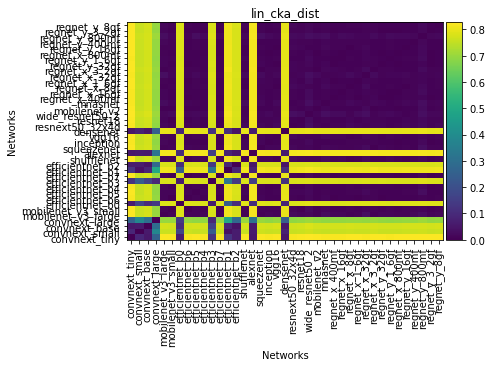

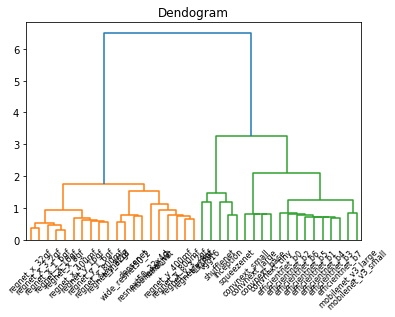

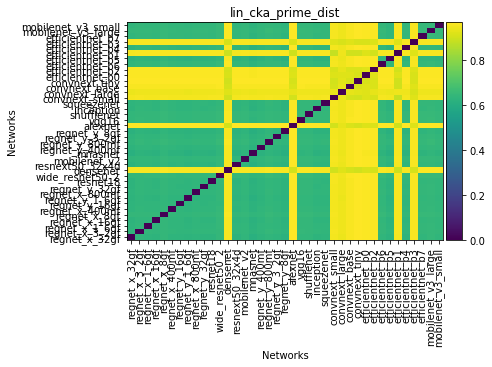

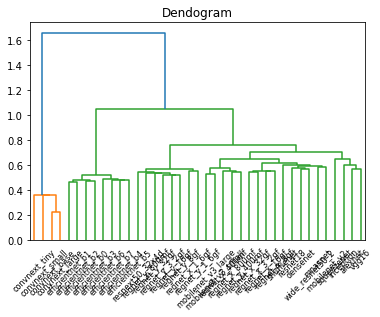

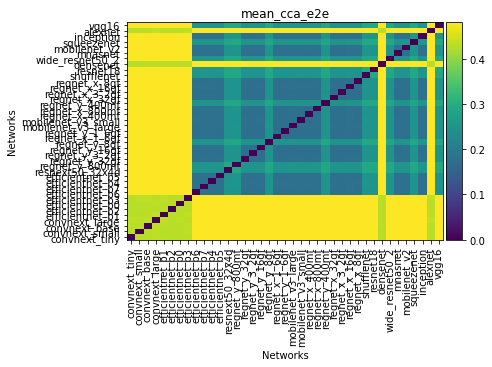

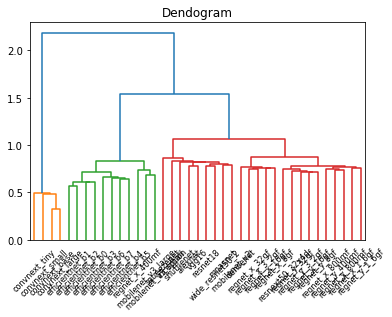

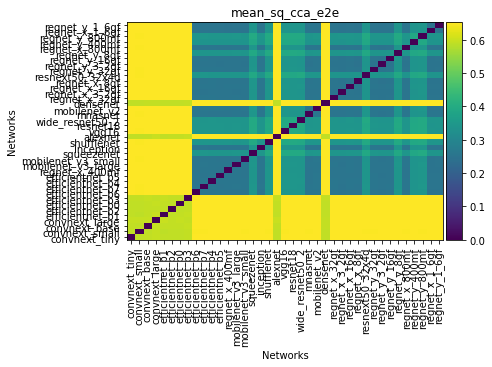

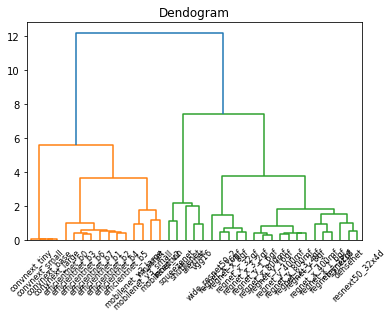

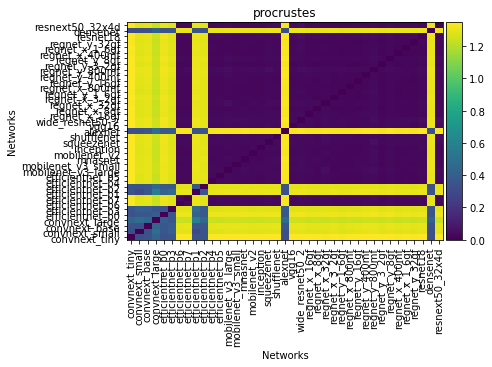

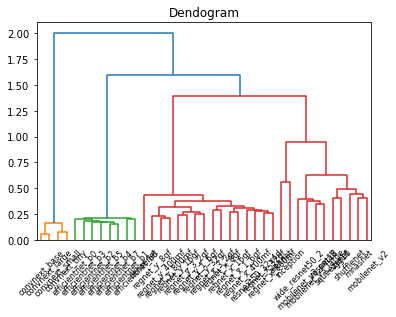

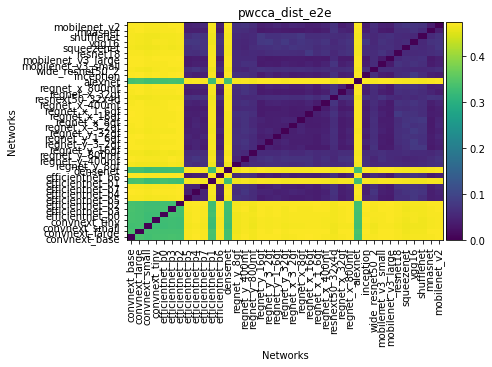

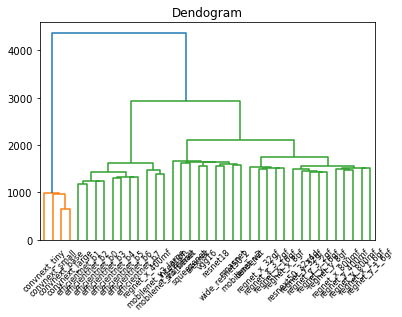

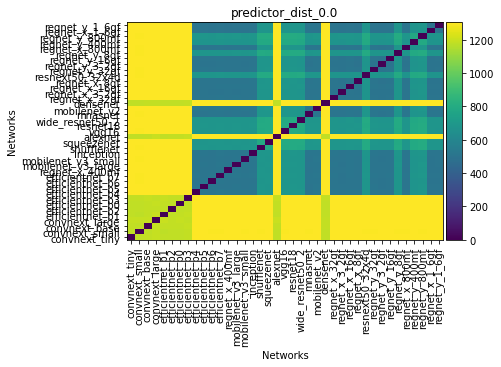

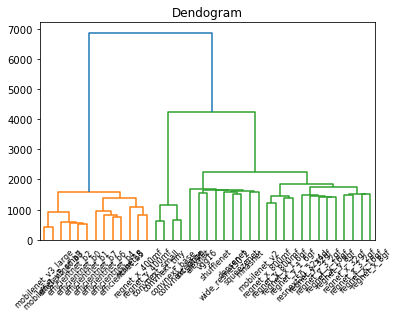

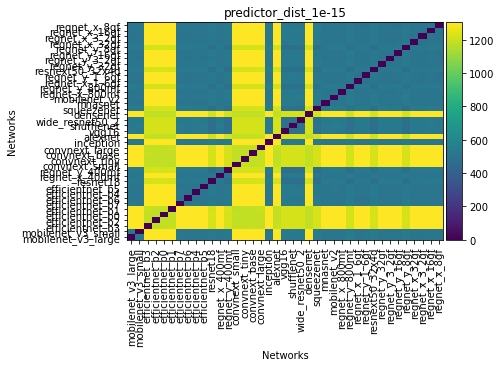

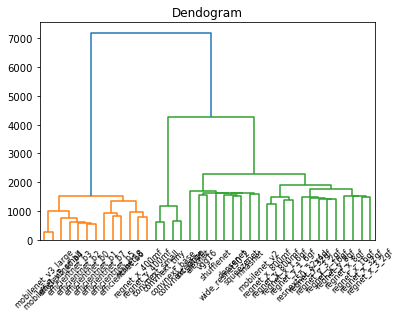

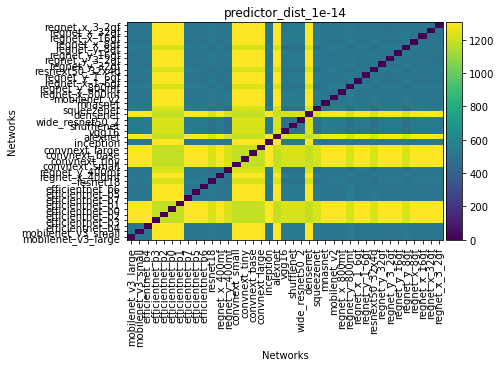

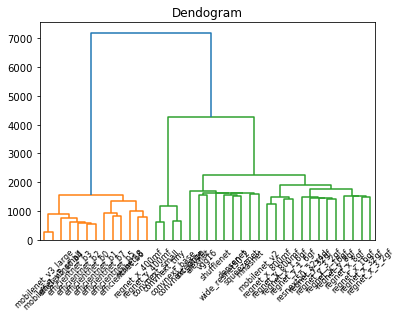

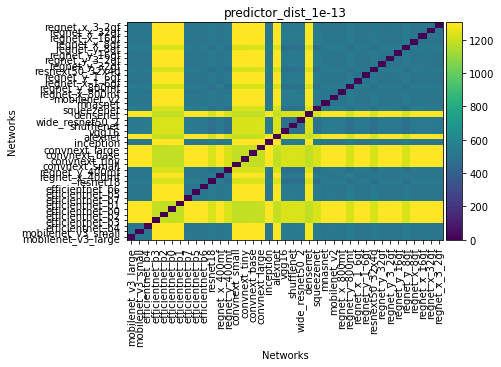

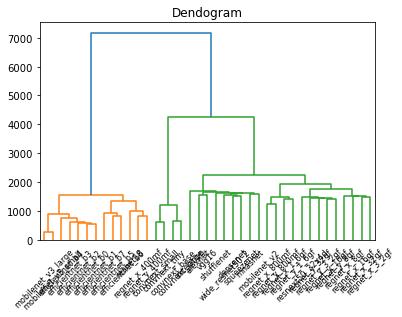

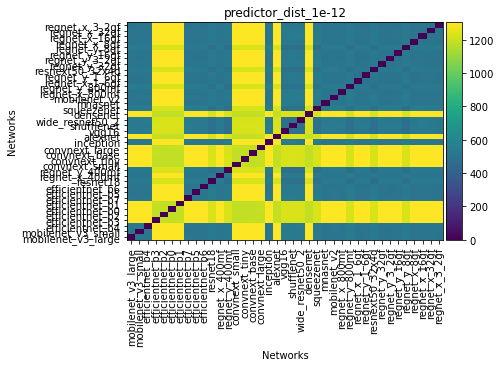

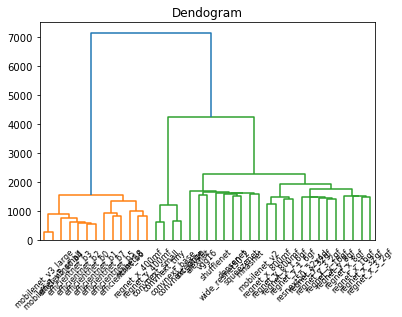

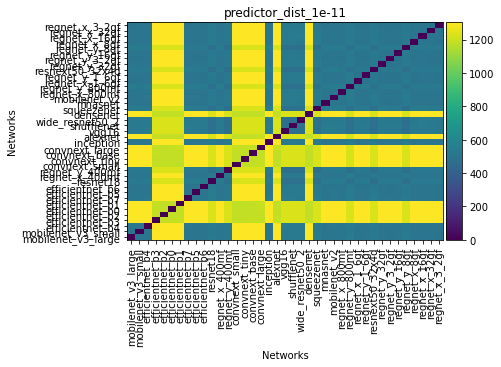

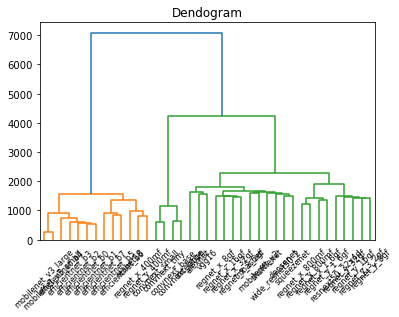

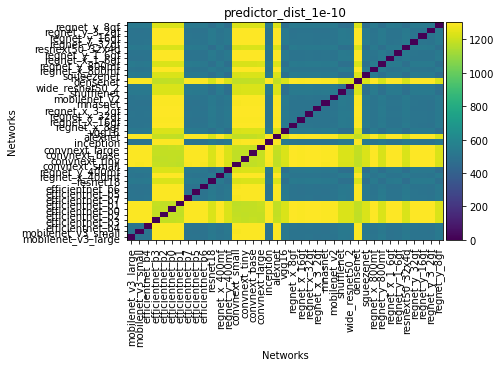

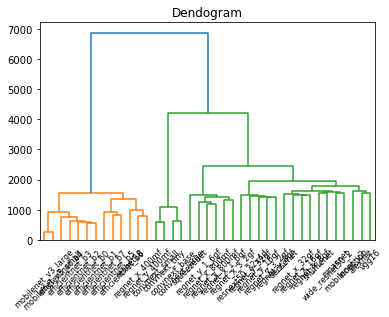

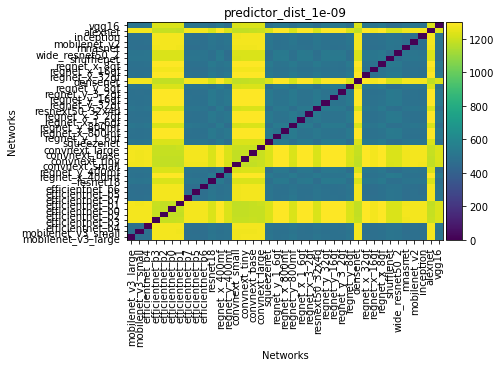

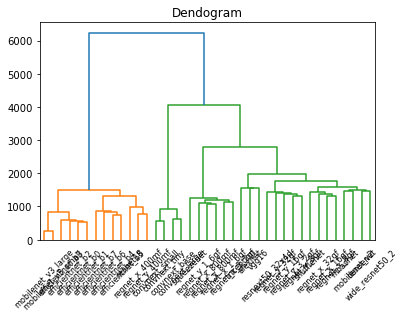

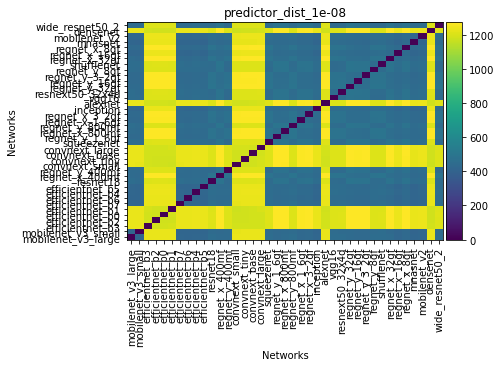

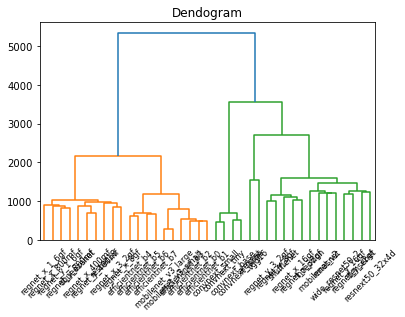

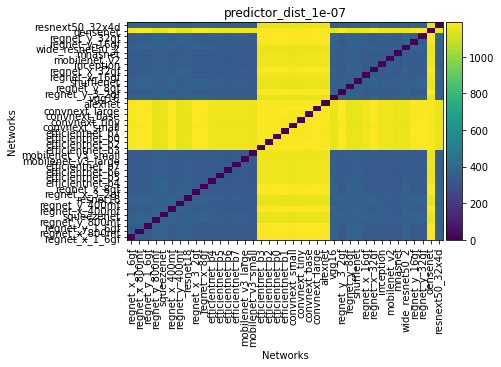

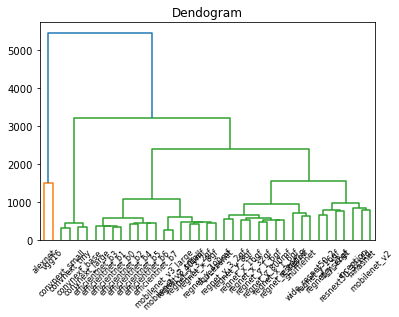

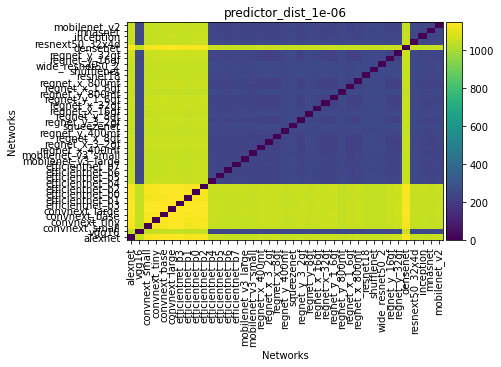

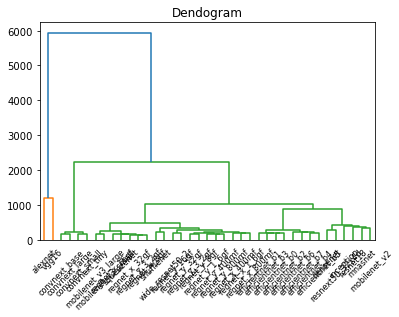

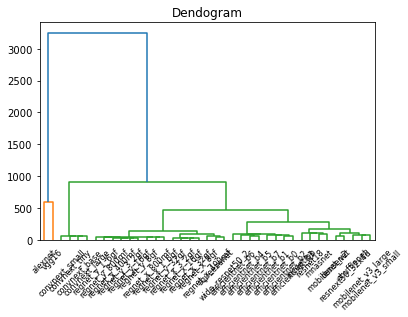

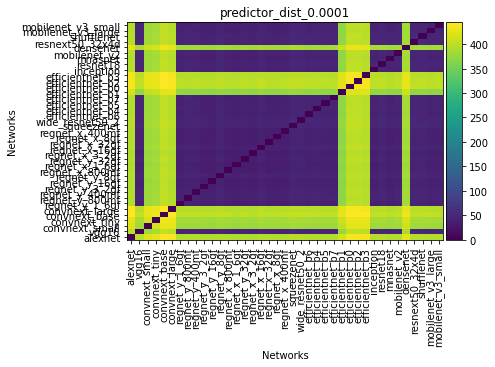

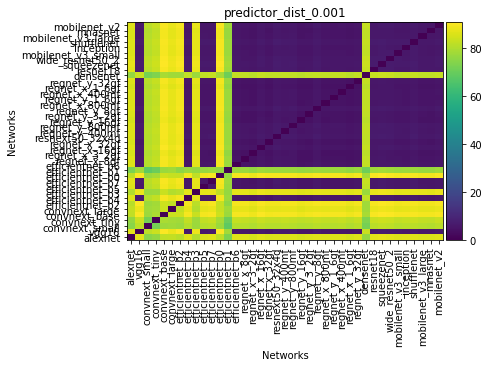

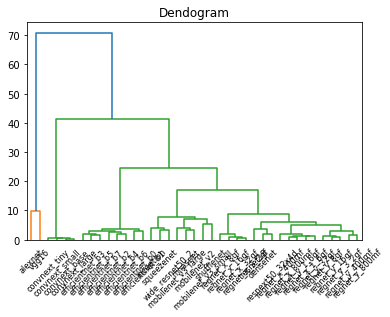

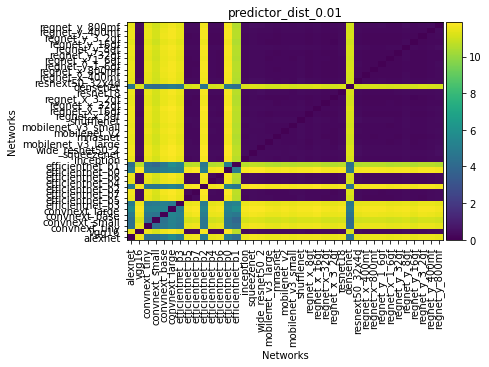

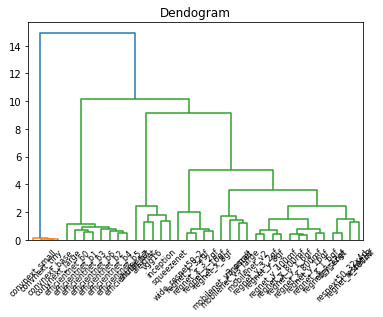

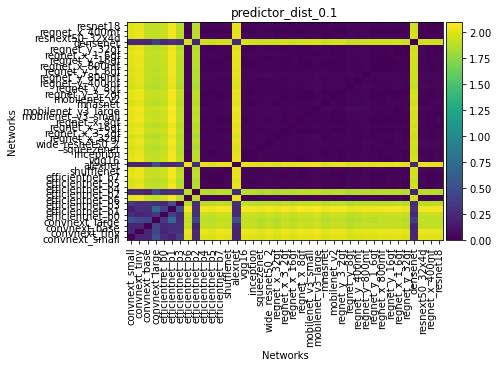

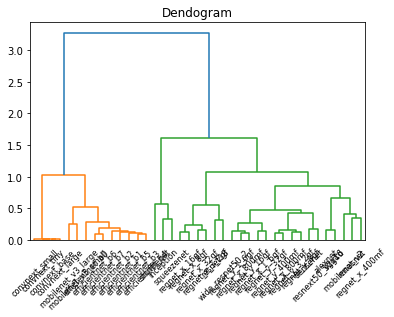

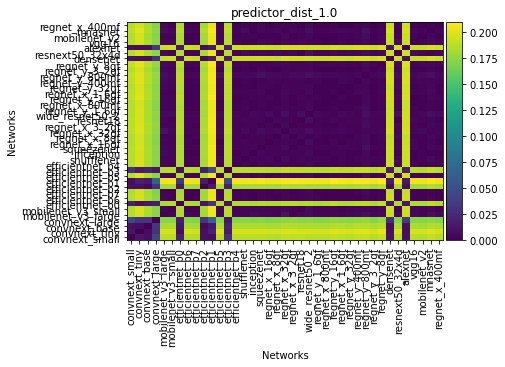

In [20]:
stats = np.load(f"distances/{subset}/untrained/stats.npz")
stats_model_names = np.sort([x[:-4] for x in stats["model_names"]])
assert np.all(stats_model_names == untrained_model_names)

short_model_names = np.array(["_".join(name.split("_")[:-1]) for name in untrained_model_names])
unique_short_model_names = np.unique(short_model_names)
num_unique_models = len(unique_short_model_names)

for distname in distnames:
    D = np.load(f'distances/{subset}/untrained/{distname}.npy')
    D = np.reshape(D, [num_untrained_models, num_untrained_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    
    # take strided average of large distance matrix
    num_copies = 10
    num_nets = num_untrained_models // num_copies
    D_ave = np.zeros((num_nets, num_nets))
    for i in range(num_nets):
        for j in range(i, num_nets):
            for ii in range(num_copies):
                for jj in range(ii+1, num_copies):
                    D_ave[i, j] += D[num_copies*i+ii, num_copies*j+jj]
    D_ave /= num_copies*(num_copies)/2
    D_ave = symmetrize(D_ave)
    np.fill_diagonal(D_ave, 0)
    
    Z = linkage(pdist(D_ave), 'ward')
    fig, ax = plt.subplots()
    dendrogram(Z, labels=unique_short_model_names, ax=ax)
    ax.set_title("Dendogram")
    plt.show()
    sorted_inds = leaves_list(Z)
    
    fig, ax = plt.subplots()
    im = ax.pcolormesh(D[sorted_inds][:, sorted_inds])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title(distname)
    ax.set_yticks(np.arange(num_unique_models) + 0.5)
    ax.set_yticklabels(unique_short_model_names[sorted_inds])
    ax.set_ylabel("Networks")
    ax.set_xticks(np.arange(num_unique_models) + 0.5)
    ax.set_xticklabels(unique_short_model_names[sorted_inds], rotation=90)
    ax.set_xlabel("Networks")
    plt.show()

In [18]:
distname = "predictor_dist_1.0" #"procrustes"

D = np.load(f'distances/{subset}/untrained/{distname}.npy')
D = np.reshape(D, [num_untrained_models, num_untrained_models])
D = symmetrize(D)
np.fill_diagonal(D, 0)

Z = linkage(pdist(D), 'ward')
sorted_inds = leaves_list(Z)

In [21]:
embed_type = "TSNE"

if embed_type == "TSNE":
    X_embedded = TSNE(n_components=2, perplexity=20.0, init="random", metric="precomputed").fit_transform(D)
elif embed_type == "UMAP":
    X_embedded = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1).fit_transform(D)
elif embed_type == "MDS":
    X_embedded = MDS(n_components=2, dissimilarity="precomputed").fit_transform(D)

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


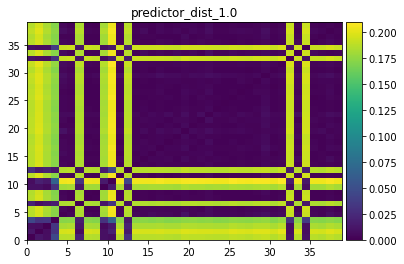

ValueError: Dimensions of Z and labels must be consistent.

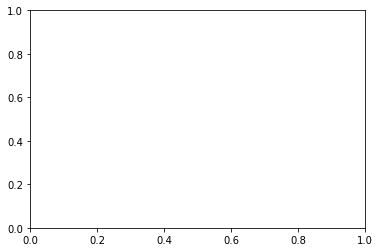

In [22]:
fig, ax = plt.subplots()
# plot distance matrix ordered by hierarchical clustering
im = ax.pcolormesh(D[sorted_inds][:, sorted_inds])
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_title(distname)
#ax.set_yticks(np.arange(num_unique_short_models) + 0.5)
#ax.set_yticklabels(untrained_model_names[sorted_inds])
#ax.set_ylabel("Networks")
#ax.set_xticks(np.arange(num_untrained_models) + 0.5)
#ax.set_xticklabels(untrained_model_names[sorted_inds], rotation=90)
#ax.set_xlabel("Networks")
plt.show()

# plot hierarchical clustering
fig, ax = plt.subplots()
dendrogram(Z, labels=untrained_model_names, ax=ax)
ax.set_title("Dendogram")
plt.show()

# plot network embedding colored by major network groups
cmap = plt.cm.tab10
colors = [cmap(i) for i in range(num_classes)]

plt.figure(dpi=1000)
other_inds = np.ones(len(short_model_names), dtype=bool)
for i in range(num_classes):
    class_inds = np.in1d(short_model_names, classes[class_names[i]])
    other_inds = other_inds & ~class_inds
    plt.scatter(X_embedded[class_inds, 0], X_embedded[class_inds, 1], s=2, color=colors[i])
plt.scatter(X_embedded[other_inds, 0], X_embedded[other_inds, 1], s=2, color="gray")
for i in range(num_untrained_models):
    plt.text(X_embedded[i, 0], X_embedded[i, 1], short_model_names[i], fontsize=1, horizontalalignment="center", verticalalignment="bottom")
plt.title(f"{embed_type} embedding for {distname}")
plt.legend(np.append(class_names, "other"))
plt.xlim([np.min(X_embedded[:, 0]), np.max(X_embedded[:, 0])])
plt.show()

# plot network embedding colored by individual network architecture
cmap = plt.cm.gist_ncar
colors = [cmap(i/num_unique_models) for i in range(num_unique_models)]

plt.figure(dpi=1000)
for i in range(num_unique_models):
    class_inds = (short_model_names == unique_short_model_names[i])
    plt.scatter(X_embedded[class_inds, 0], X_embedded[class_inds, 1], s=2, color=colors[i])
for i in range(num_untrained_models):
    plt.text(X_embedded[i, 0], X_embedded[i, 1], short_model_names[i], fontsize=1, horizontalalignment="center", verticalalignment="bottom")
plt.title(f"{embed_type} embedding for {distname}")
plt.legend(unique_short_model_names, fontsize=3)
plt.xlim([np.min(X_embedded[:, 0]), np.max(X_embedded[:, 0])])
plt.show()

## Variance ratio plots for untrained and pretrained networks

In [14]:
pretrained_subset_inds = []
for j in range(num_classes):
    class_inds = np.where(np.in1d(short_pretrained_model_names, classes[class_names[j]]))[0]
    pretrained_subset_inds.append(class_inds)
pretrained_subset_inds = np.sort(np.hstack(pretrained_subset_inds))
num_pretrained_subset = len(pretrained_subset_inds)

untrained_subset_inds = []
for j in range(num_classes):
    class_inds = np.where(np.in1d(short_untrained_model_names, classes[class_names[j]]))[0]
    untrained_subset_inds.append(class_inds)
untrained_subset_inds = np.sort(np.hstack(untrained_subset_inds))
num_untrained_subset = len(untrained_subset_inds)

In [15]:
num_dists = len(distnames)
pretrained_variance_ratio = np.zeros((num_dists, num_classes))
for i in range(num_dists):
    for j in range(num_classes):
        D = np.load(f'distances/{subset}/pretrained/{distnames[i]}.npy')
        D = np.reshape(D, [num_pretrained_models, num_pretrained_models])
        D = symmetrize(D)
        np.fill_diagonal(D, 0)
        D_subset = D[pretrained_subset_inds, :][:, pretrained_subset_inds]

        class_inds = np.in1d(short_pretrained_model_names, classes[class_names[j]])
        print(class_names[j])
        print(pretrained_model_names[class_inds])
        n_class = np.sum(class_inds)
        class_variance = np.sum(D[class_inds][:, class_inds]) / (2*n_class*(n_class-1))
        total_variance = np.sum(D_subset) / (2*num_pretrained_subset*(num_pretrained_subset-1))
        pretrained_variance_ratio[i, j] = class_variance / total_variance

resnet
['regnet_x_16gf_pretrained' 'regnet_x_1_6gf_pretrained'
 'regnet_x_32gf_pretrained' 'regnet_x_3_2gf_pretrained'
 'regnet_x_400mf_pretrained' 'regnet_x_800mf_pretrained'
 'regnet_x_8gf_pretrained' 'regnet_y_16gf_pretrained'
 'regnet_y_1_6gf_pretrained' 'regnet_y_32gf_pretrained'
 'regnet_y_3_2gf_pretrained' 'regnet_y_400mf_pretrained'
 'regnet_y_800mf_pretrained' 'regnet_y_8gf_pretrained'
 'resnet18_pretrained' 'resnext50_32x4d_pretrained'
 'wide_resnet50_2_pretrained']
efficientnet
['efficientnet_b0_pretrained' 'efficientnet_b1_pretrained'
 'efficientnet_b2_pretrained' 'efficientnet_b3_pretrained'
 'efficientnet_b4_pretrained' 'efficientnet_b5_pretrained'
 'efficientnet_b6_pretrained' 'efficientnet_b7_pretrained']
mobilenet
['mobilenet_v2_pretrained' 'mobilenet_v3_large_pretrained'
 'mobilenet_v3_small_pretrained']
convnext
['convnext_base_pretrained' 'convnext_large_pretrained'
 'convnext_small_pretrained' 'convnext_tiny_pretrained']
vit
['vit_b_16_pretrained' 'vit_b_32_pretrai

resnet
['regnet_x_16gf_pretrained' 'regnet_x_1_6gf_pretrained'
 'regnet_x_32gf_pretrained' 'regnet_x_3_2gf_pretrained'
 'regnet_x_400mf_pretrained' 'regnet_x_800mf_pretrained'
 'regnet_x_8gf_pretrained' 'regnet_y_16gf_pretrained'
 'regnet_y_1_6gf_pretrained' 'regnet_y_32gf_pretrained'
 'regnet_y_3_2gf_pretrained' 'regnet_y_400mf_pretrained'
 'regnet_y_800mf_pretrained' 'regnet_y_8gf_pretrained'
 'resnet18_pretrained' 'resnext50_32x4d_pretrained'
 'wide_resnet50_2_pretrained']
efficientnet
['efficientnet_b0_pretrained' 'efficientnet_b1_pretrained'
 'efficientnet_b2_pretrained' 'efficientnet_b3_pretrained'
 'efficientnet_b4_pretrained' 'efficientnet_b5_pretrained'
 'efficientnet_b6_pretrained' 'efficientnet_b7_pretrained']
mobilenet
['mobilenet_v2_pretrained' 'mobilenet_v3_large_pretrained'
 'mobilenet_v3_small_pretrained']
convnext
['convnext_base_pretrained' 'convnext_large_pretrained'
 'convnext_small_pretrained' 'convnext_tiny_pretrained']
vit
['vit_b_16_pretrained' 'vit_b_32_pretrai

resnet
['regnet_x_16gf_pretrained' 'regnet_x_1_6gf_pretrained'
 'regnet_x_32gf_pretrained' 'regnet_x_3_2gf_pretrained'
 'regnet_x_400mf_pretrained' 'regnet_x_800mf_pretrained'
 'regnet_x_8gf_pretrained' 'regnet_y_16gf_pretrained'
 'regnet_y_1_6gf_pretrained' 'regnet_y_32gf_pretrained'
 'regnet_y_3_2gf_pretrained' 'regnet_y_400mf_pretrained'
 'regnet_y_800mf_pretrained' 'regnet_y_8gf_pretrained'
 'resnet18_pretrained' 'resnext50_32x4d_pretrained'
 'wide_resnet50_2_pretrained']
efficientnet
['efficientnet_b0_pretrained' 'efficientnet_b1_pretrained'
 'efficientnet_b2_pretrained' 'efficientnet_b3_pretrained'
 'efficientnet_b4_pretrained' 'efficientnet_b5_pretrained'
 'efficientnet_b6_pretrained' 'efficientnet_b7_pretrained']
mobilenet
['mobilenet_v2_pretrained' 'mobilenet_v3_large_pretrained'
 'mobilenet_v3_small_pretrained']
convnext
['convnext_base_pretrained' 'convnext_large_pretrained'
 'convnext_small_pretrained' 'convnext_tiny_pretrained']
vit
['vit_b_16_pretrained' 'vit_b_32_pretrai

In [16]:
untrained_variance_ratio = np.zeros((num_dists, num_classes-1)) # untrained VIT networks not used
for i in range(num_dists):
    for j in range(num_classes-1):
        D = np.load(f'distances/{subset}/untrained/{distnames[i]}.npy')
        D = np.reshape(D, [num_untrained_models, num_untrained_models])
        D = symmetrize(D)
        np.fill_diagonal(D, 0)
        D_subset = D[untrained_subset_inds, :][:, untrained_subset_inds]
        
        class_inds = np.in1d(short_untrained_model_names, classes[class_names[j]])
        n_class = np.sum(class_inds)
        class_variance = np.sum(D[class_inds][:, class_inds]) / (2*n_class*(n_class-1))
        total_variance = np.sum(D_subset) / (2*num_untrained_subset*(num_untrained_subset-1))
        untrained_variance_ratio[i, j] = class_variance / total_variance

In [17]:
embed_type = "TSNE"

num_dists = len(distnames)

pretrained_embeddings = np.zeros((num_dists, num_pretrained_subset, 2))
for i in range(num_dists):
    print(f"Pretrained Networks: {distnames[i]}")
    D = np.load(f'distances/{subset}/pretrained/{distnames[i]}.npy')
    D = np.reshape(D, [num_pretrained_models, num_pretrained_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    D_subset = D[pretrained_subset_inds, :][:, pretrained_subset_inds]
    
    if np.any(D_subset < 0):
        pretrained_embeddings[i, :, :] = np.nan
        continue

    if embed_type == "TSNE":
        X_embedded = TSNE(n_components=2, perplexity=20.0, init="random", metric="precomputed").fit_transform(D_subset)
    elif embed_type == "UMAP":
        X_embedded = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1).fit_transform(np.sqrt(D_subset))
    elif embed_type == "MDS":
        X_embedded = MDS(n_components=2, dissimilarity="precomputed").fit_transform(np.sqrt(D_subset))

    pretrained_embeddings[i, :, :] = X_embedded

Pretrained Networks: lin_cka_dist


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: lin_cka_prime_dist


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: mean_cca_e2e


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: mean_sq_cca_e2e


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: procrustes


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: pwcca_dist_e2e


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_0.0


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-20


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-19


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-18


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-17


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-16


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-15


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-14


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-13


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-12


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-11


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-10


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-09


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-08


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-07


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-06


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1e-05


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_0.0001


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_0.001


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_0.01


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_0.1


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1.0


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_10.0


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_100.0


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_1000.0


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Pretrained Networks: predictor_dist_10000.0


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [18]:
untrained_embeddings = np.zeros((num_dists, num_untrained_subset, 2))
for i in range(num_dists):
    print(f"Untrained Networks: {distnames[i]}")
    D = np.load(f'distances/{subset}/untrained/{distnames[i]}.npy')
    D = np.reshape(D, [num_untrained_models, num_untrained_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    D_subset = D[untrained_subset_inds, :][:, untrained_subset_inds]
    
    if np.any(D_subset < 0):
        untrained_embeddings[i, :, :] = np.nan
        continue
    
    if embed_type == "TSNE":
        X_embedded = TSNE(n_components=2, perplexity=20.0, init="random", metric="precomputed").fit_transform(D_subset)
    elif embed_type == "UMAP":
        X_embedded = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1).fit_transform(np.sqrt(D_subset))
    elif embed_type == "MDS":
        X_embedded = MDS(n_components=2, dissimilarity="precomputed").fit_transform(np.sqrt(D_subset))

    untrained_embeddings[i, :, :] = X_embedded

Untrained Networks: lin_cka_dist


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: lin_cka_prime_dist


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: mean_cca_e2e


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: mean_sq_cca_e2e


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: procrustes


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: pwcca_dist_e2e


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_0.0


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_1e-20
Untrained Networks: predictor_dist_1e-19


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_1e-18


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_1e-17


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_1e-16


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_1e-15


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_1e-14


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_1e-13


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_1e-12


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_1e-11


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_1e-10


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_1e-09


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_1e-08


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_1e-07


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_1e-06


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_1e-05


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_0.0001


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_0.001


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_0.01


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_0.1


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_1.0


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_10.0


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_100.0


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_1000.0


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Untrained Networks: predictor_dist_10000.0


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


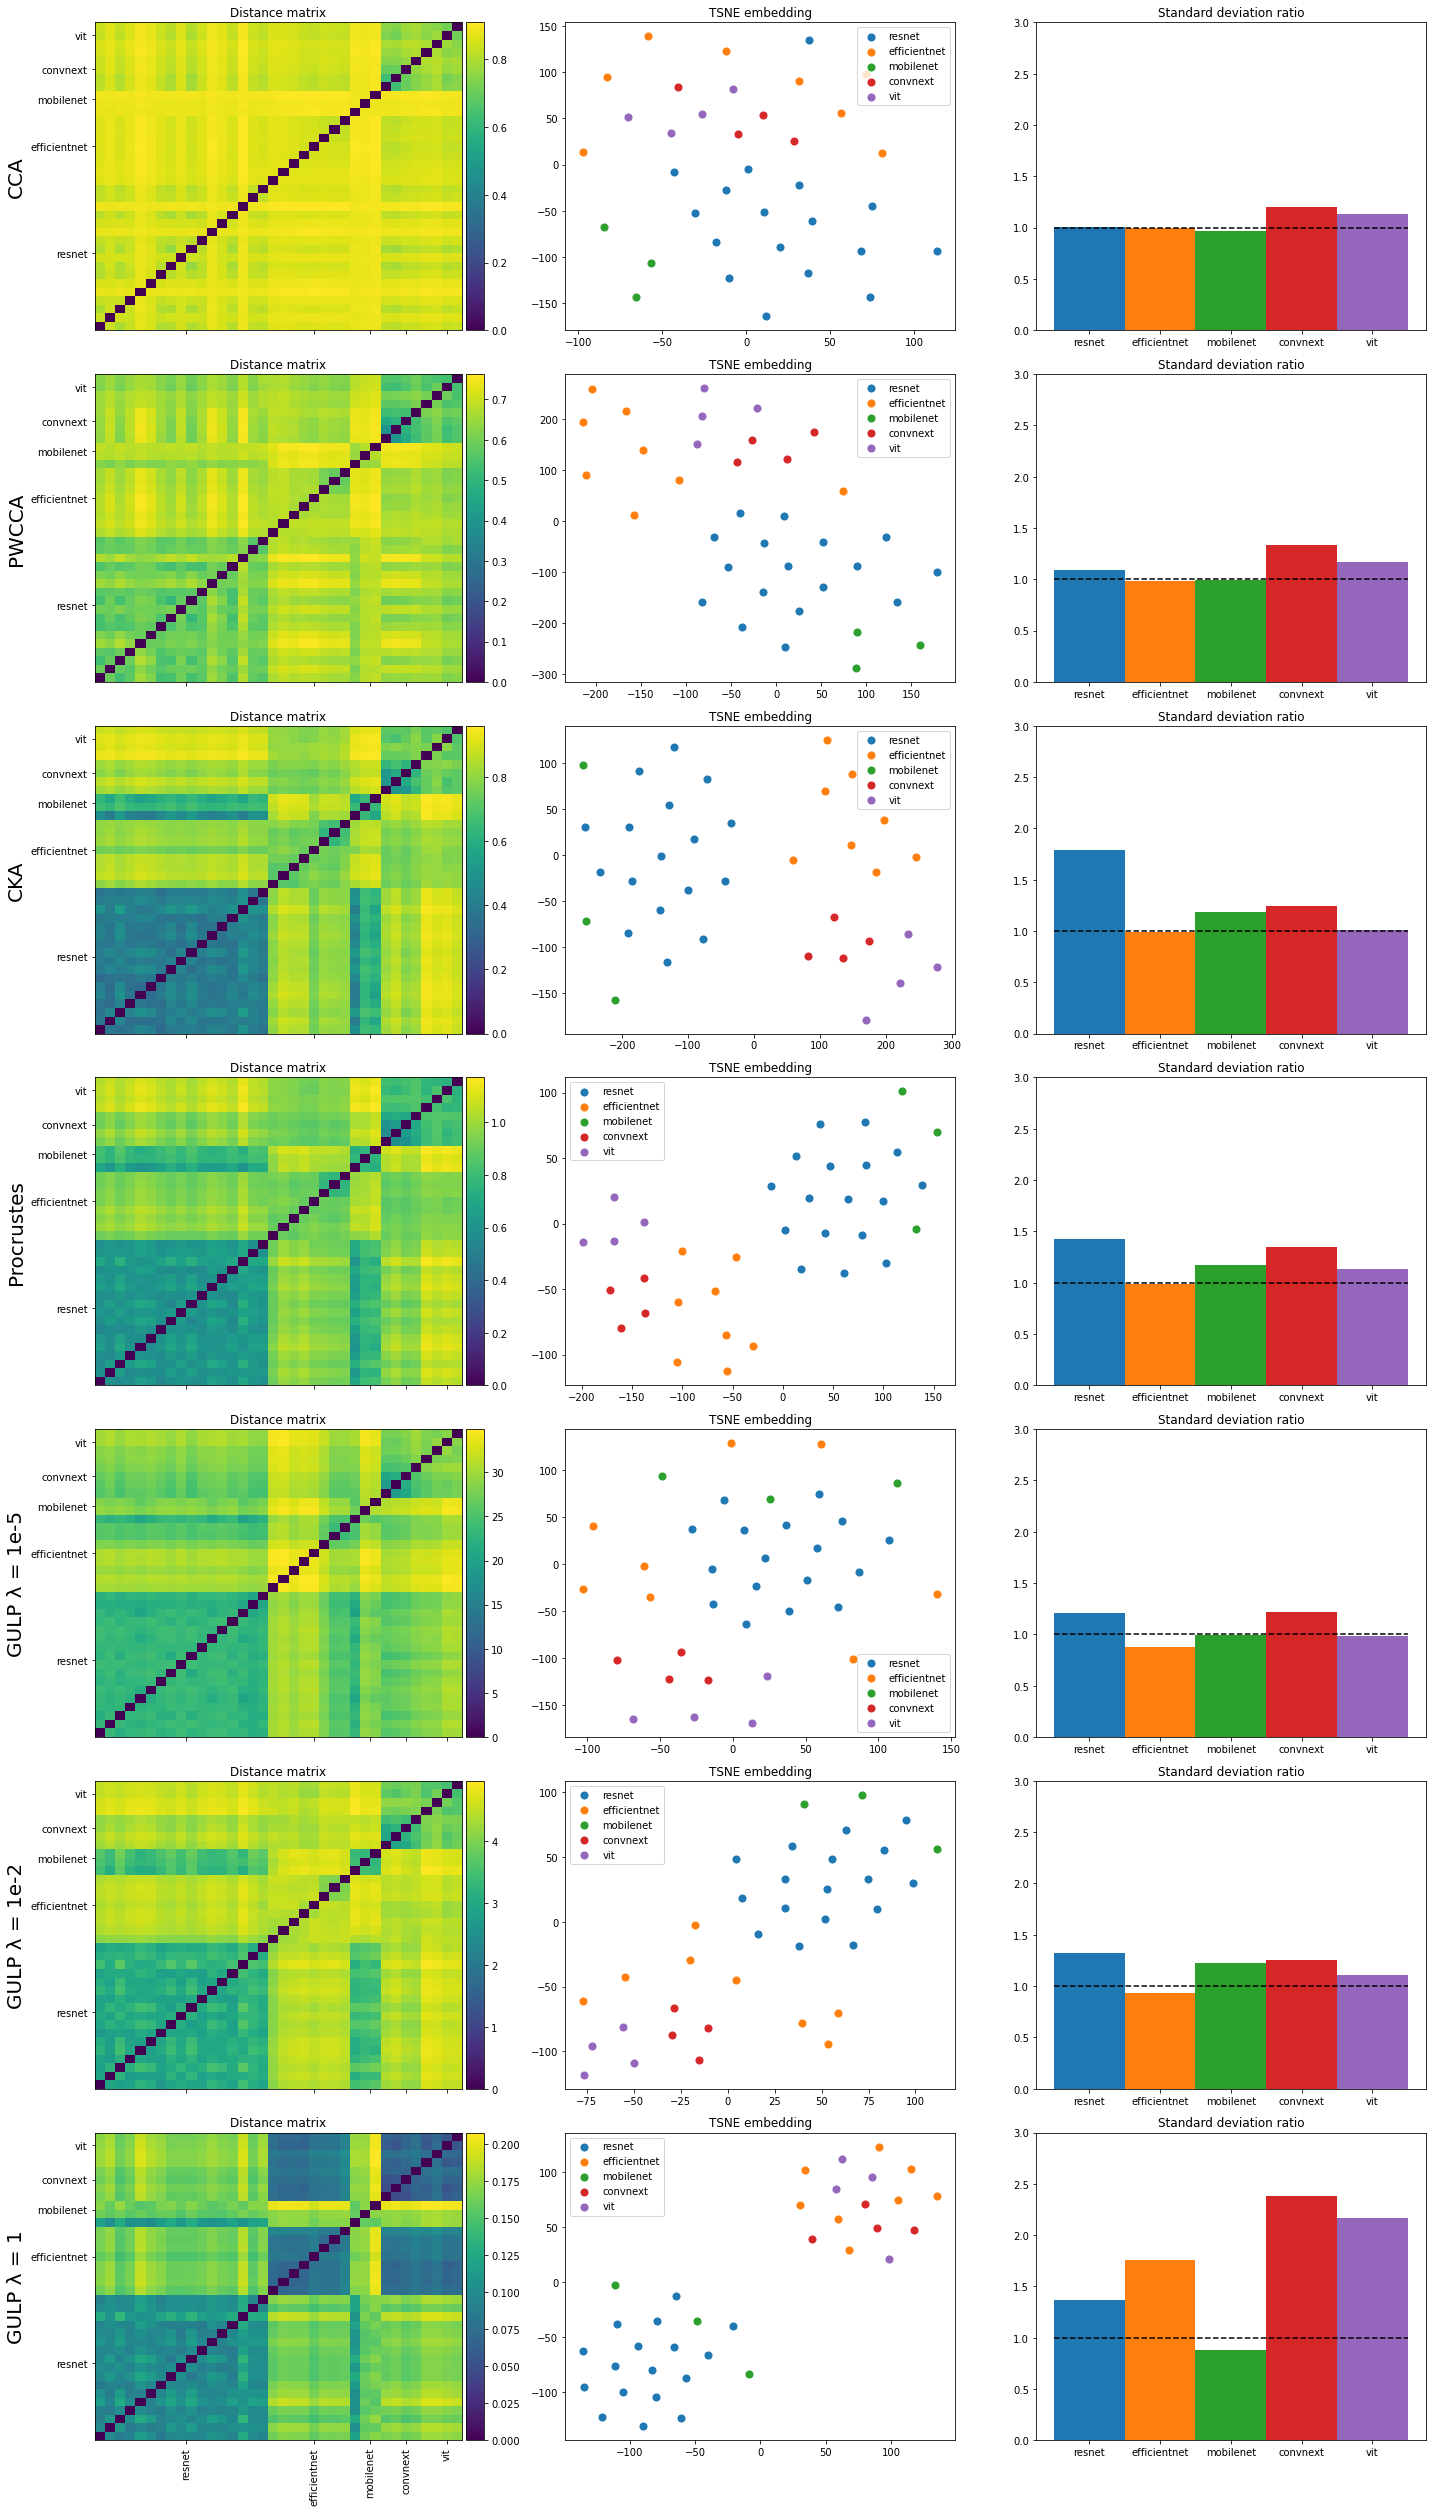

In [74]:
dist_inds = [3, 5, 0, 4, 22, 25, 27]

labels = ['CCA', 'PWCCA', 'CKA', 'Procrustes', 'GULP λ = 1e-5', 'GULP λ = 1e-2', 'GULP λ = 1']
#labels = distnames[dist_inds]

cmap = plt.cm.tab10
colors = [cmap(i) for i in range(num_classes)]

fig, axs = plt.subplots(len(dist_inds), 3, figsize=(20, 35))

sorted_inds = np.array([], dtype=int)
spacings = []
for name in class_names:
    class_inds = np.where(np.in1d(short_pretrained_model_names, classes[name]))[0]
    spacings.append(len(sorted_inds) + len(class_inds)/2)
    sorted_inds = np.append(sorted_inds, class_inds)
spacings = np.array(spacings)

for i in range(len(dist_inds)):
    D = np.load(f'distances/{subset}/pretrained/{distnames[dist_inds[i]]}.npy')
    D = np.reshape(D, [num_pretrained_models, num_pretrained_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    
    ax = axs[i, 0]
    im = ax.pcolormesh(np.sqrt(D[sorted_inds][:, sorted_inds]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title("Distance matrix")
    ax.set_yticks(spacings + 0.5)
    ax.set_yticklabels(class_names)
    ax.set_ylabel(labels[i], fontsize=20)
    ax.set_xticks(spacings + 0.5)
    if i == len(dist_inds)-1:
        ax.set_xticklabels(class_names, rotation=90)
    else:
        ax.set_xticklabels([])
    
    ax = axs[i, 1]
    X_embedded = pretrained_embeddings[dist_inds[i], :, :]
    for j in range(num_classes):
        class_inds = np.in1d(short_pretrained_model_names[pretrained_subset_inds], classes[class_names[j]])
        ax.scatter(X_embedded[class_inds, 0], X_embedded[class_inds, 1], s=50, color=colors[j])
    ax.set_title(f"{embed_type} embedding")
    ax.legend(class_names)
    
    ax = axs[i, 2]
    ax.bar(np.arange(num_classes), 1/np.sqrt(pretrained_variance_ratio[dist_inds[i], :]), color=colors, width = 1)
    ax.set_title("Standard deviation ratio")
    ax.set_xticks(np.arange(num_classes))
    ax.set_xticklabels(class_names)
    ax.hlines(1, -0.5, num_classes-0.5, linestyle="dashed", color="k")
    ax.set_ylim(0, 3)
fig.tight_layout()
plt.savefig("/home/gridsan/gstepaniants/geometric_toolkit_shared/paper_figures/imagenet_pretrained_variance_lambda.pdf")
plt.show()

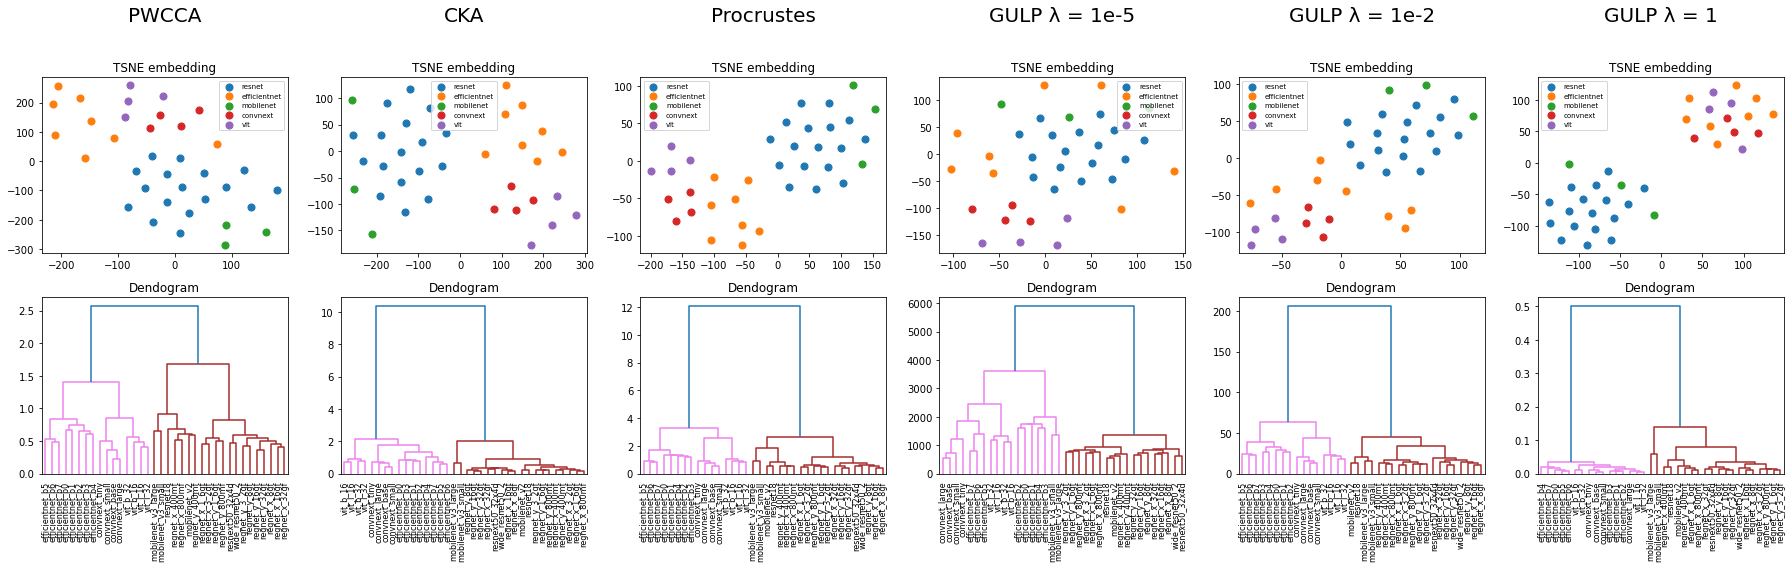

In [75]:
hierarchy.set_link_color_palette(['violet', 'brown'])

dist_inds = [5, 0, 4, 22, 25, 27] #np.arange(14, 23, 4)

labels = ['PWCCA', 'CKA', 'Procrustes', 'GULP λ = 1e-5', 'GULP λ = 1e-2', 'GULP λ = 1']
#labels = distnames[dist_inds]

cmap = plt.cm.tab10
colors = [cmap(i) for i in range(num_classes)]

fig, axs = plt.subplots(3, len(dist_inds), figsize=(25, 8), gridspec_kw={'height_ratios': [1, 30, 30]})

for i in range(len(dist_inds)):
    ax = axs[0, i]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(labels[i], fontsize=20)
    
    ax = axs[1, i]
    X_embedded = pretrained_embeddings[dist_inds[i], :, :]
    for j in range(num_classes):
        class_inds = np.in1d(short_pretrained_model_names[pretrained_subset_inds], classes[class_names[j]])
        ax.scatter(X_embedded[class_inds, 0], X_embedded[class_inds, 1], s=50, color=colors[j])
    #for j in range(num_pretrained_models):
    #   ax.text(X_embedded[j, 0], X_embedded[j, 1], short_model_names[j], fontsize=4, horizontalalignment="center", verticalalignment="bottom")
    ax.set_title(f"{embed_type} embedding")
    ax.legend(class_names, fontsize=7)
    
    ax = axs[2, i]
    D = np.load(f'distances/{subset}/pretrained/{distnames[dist_inds[i]]}.npy')
    D = np.reshape(D, [num_pretrained_models, num_pretrained_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    D_subset = D[pretrained_subset_inds, :][:, pretrained_subset_inds]
    Z = linkage(pdist(D_subset), 'ward')
    count_sort = 'ascending'
    if i == 3:
        count_sort = 'descending'
    dendrogram(Z, labels=short_pretrained_model_names[pretrained_subset_inds], leaf_rotation=90, count_sort=count_sort, ax=ax)
    ax.set_title("Dendogram")
fig.tight_layout()
plt.savefig("/home/gridsan/gstepaniants/geometric_toolkit_shared/paper_figures/imagenet_pretrained_dendogram.pdf", bbox_inches='tight')
plt.show()

In [160]:
distnames

array(['lin_cka_dist', 'lin_cka_prime_dist', 'mean_cca_e2e',
       'mean_sq_cca_e2e', 'procrustes', 'pwcca_dist_e2e',
       'predictor_dist_0.0', 'predictor_dist_1e-20',
       'predictor_dist_1e-19', 'predictor_dist_1e-18',
       'predictor_dist_1e-17', 'predictor_dist_1e-16',
       'predictor_dist_1e-15', 'predictor_dist_1e-14',
       'predictor_dist_1e-13', 'predictor_dist_1e-12',
       'predictor_dist_1e-11', 'predictor_dist_1e-10',
       'predictor_dist_1e-09', 'predictor_dist_1e-08',
       'predictor_dist_1e-07', 'predictor_dist_1e-06',
       'predictor_dist_1e-05', 'predictor_dist_0.0001',
       'predictor_dist_0.001', 'predictor_dist_0.01',
       'predictor_dist_0.1', 'predictor_dist_1.0', 'predictor_dist_10.0',
       'predictor_dist_100.0', 'predictor_dist_1000.0',
       'predictor_dist_10000.0'], dtype='<U22')

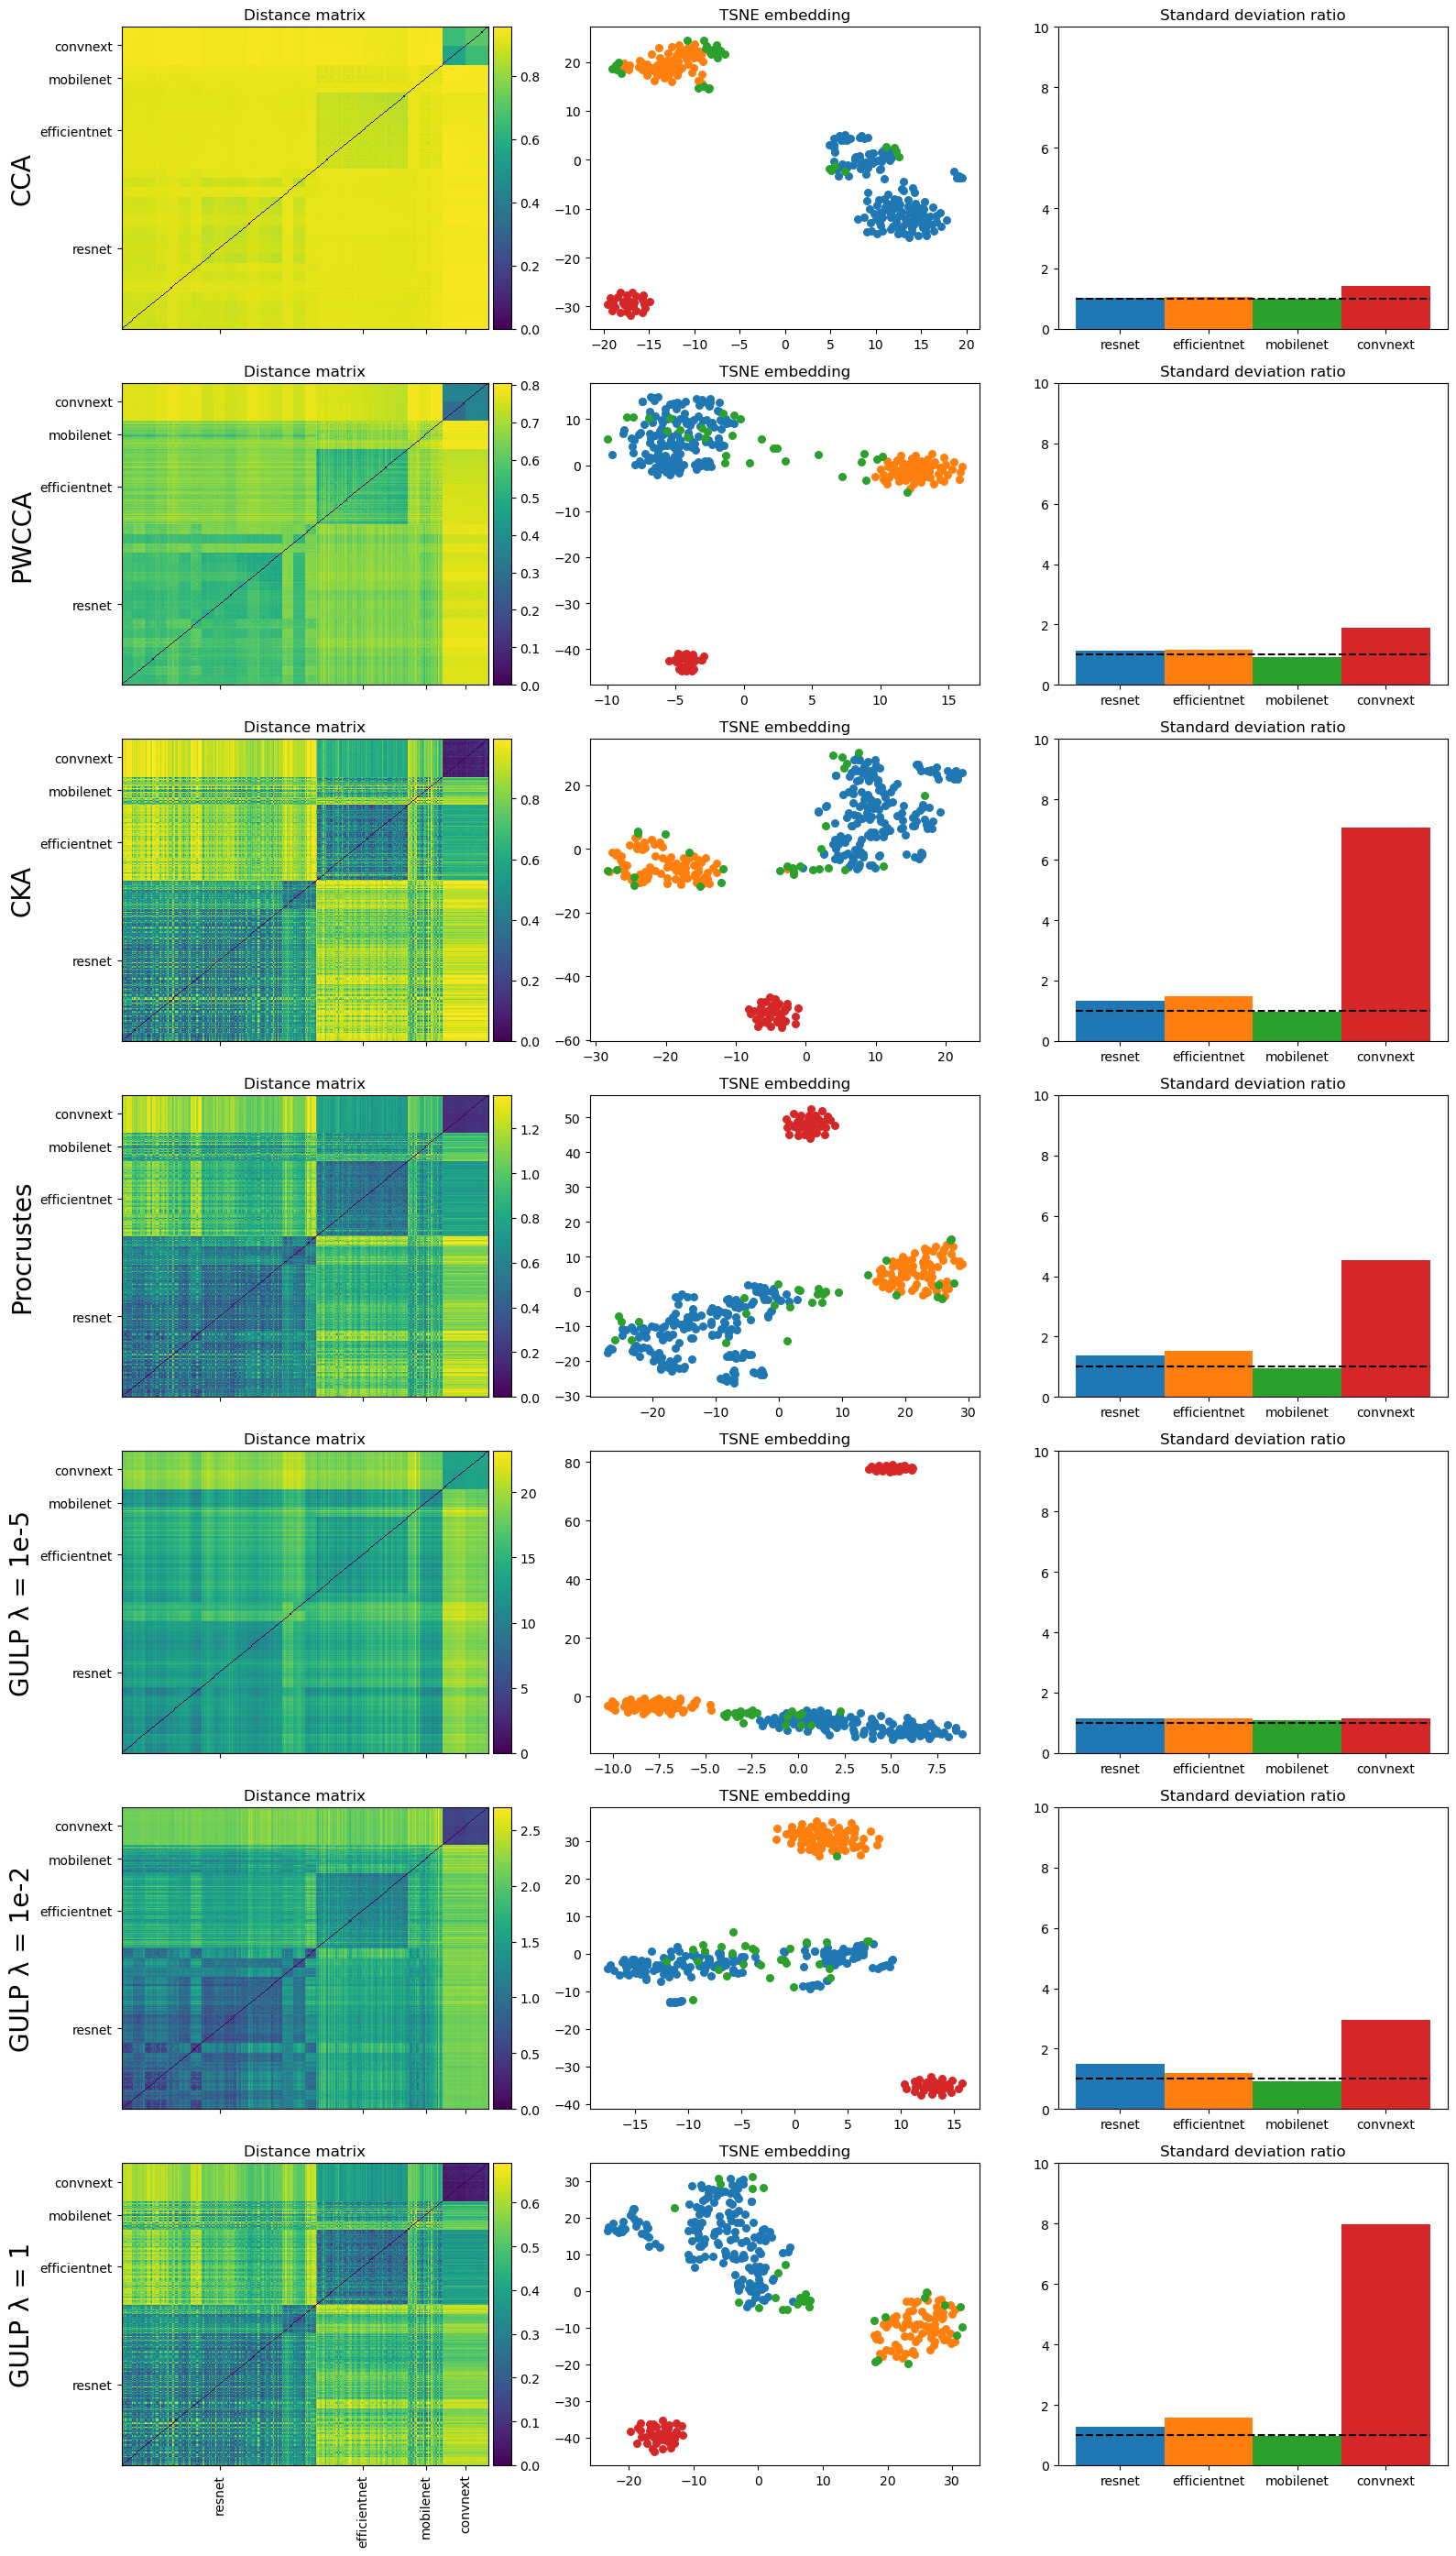

In [20]:
dist_inds = [3, 5, 0, 4, 22, 25, 27]

labels = ['CCA', 'PWCCA', 'CKA', 'Procrustes', 'GULP λ = 1e-5', 'GULP λ = 1e-2', 'GULP λ = 1']
#labels = distnames[dist_inds]

cmap = plt.cm.tab10
colors = [cmap(i) for i in range(num_classes)]

fig, axs = plt.subplots(len(dist_inds), 3, figsize=(16, 28), dpi=100)

sorted_inds = np.array([], dtype=int)
spacings = []
for name in class_names[:-1]:
    class_inds = np.where(np.in1d(short_untrained_model_names, classes[name]))[0]
    spacings.append(len(sorted_inds) + len(class_inds)/2)
    sorted_inds = np.append(sorted_inds, class_inds)
spacings = np.array(spacings)

for i in range(len(dist_inds)):
    D = np.load(f'distances/{subset}/untrained/{distnames[dist_inds[i]]}.npy')
    D = np.reshape(D, [num_untrained_models, num_untrained_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    
    ax = axs[i, 0]
    im = ax.pcolormesh(np.sqrt(D[sorted_inds][:, sorted_inds]))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title("Distance matrix")
    ax.set_yticks(spacings + 0.5)
    ax.set_yticklabels(class_names[:-1])
    ax.set_ylabel(labels[i], fontsize=20)
    ax.set_xticks(spacings + 0.5)
    if i == len(dist_inds)-1:
        ax.set_xticklabels(class_names[:-1], rotation=90)
    else:
        ax.set_xticklabels([])
    
    ax = axs[i, 1]
    X_embedded = untrained_embeddings[dist_inds[i], :, :]
    for j in range(num_classes-1):
        class_inds = np.in1d(short_untrained_model_names[untrained_subset_inds], classes[class_names[j]])
        ax.scatter(X_embedded[class_inds, 0], X_embedded[class_inds, 1], s=30, color=colors[j])
    ax.set_title(f"{embed_type} embedding")
    
    ax = axs[i, 2]
    ax.bar(np.arange(num_classes-1), 1/np.sqrt(untrained_variance_ratio[dist_inds[i], :]), color=colors, width = 1)
    ax.set_title("Standard deviation ratio")
    ax.set_xticks(np.arange(num_classes-1))
    ax.set_xticklabels(class_names[:-1])
    ax.hlines(1, -0.5, num_classes-1-0.5, linestyle="dashed", color="k")
    ax.set_ylim(0, 10)
plt.tight_layout()
plt.savefig("/home/gridsan/gstepaniants/geometric_toolkit_shared/paper_figures/imagenet_untrained_variance_lambda.png")
plt.show()

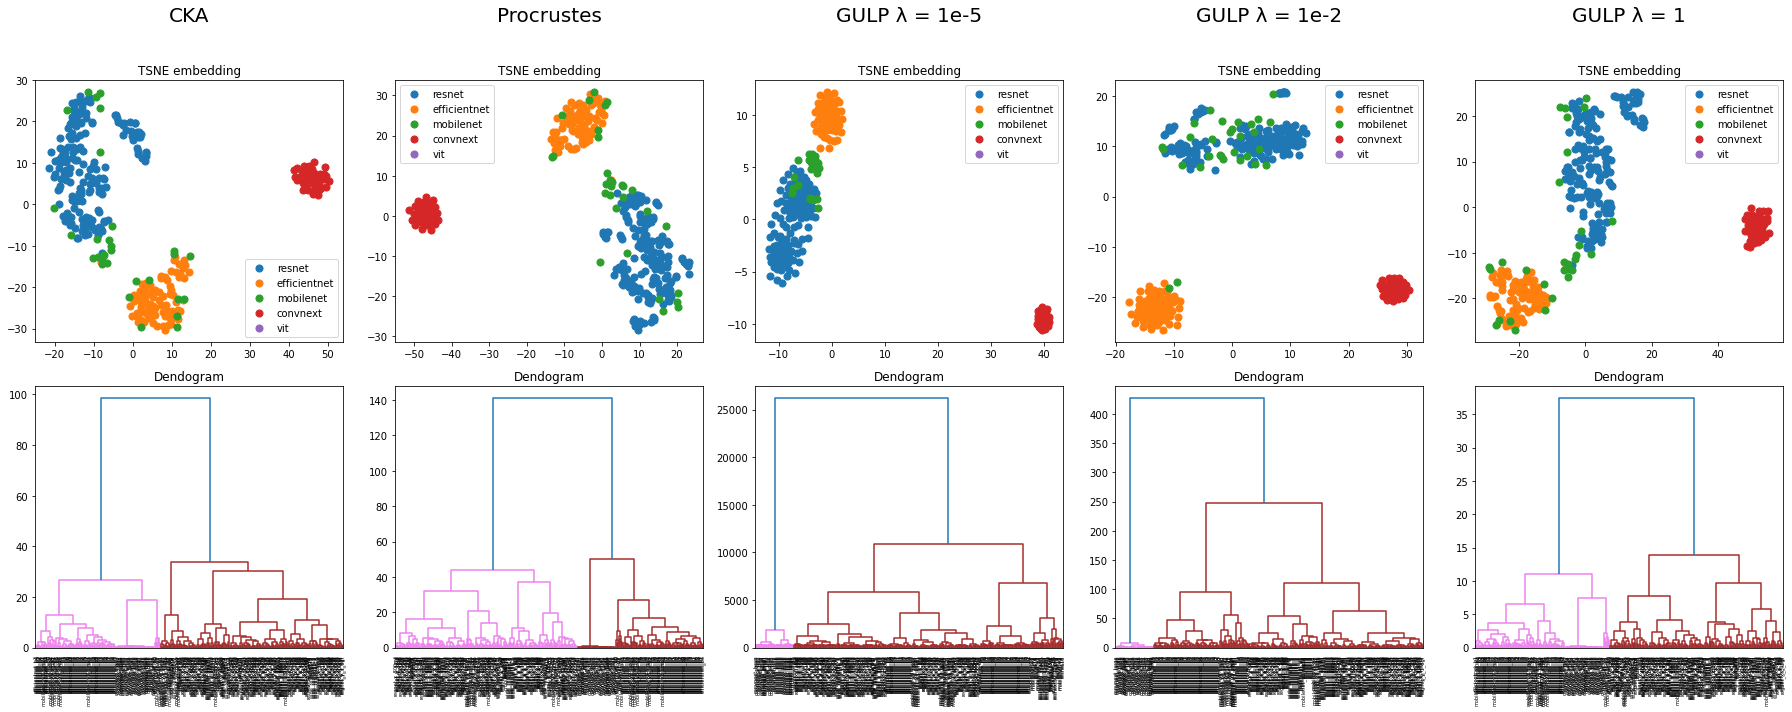

In [226]:
hierarchy.set_link_color_palette(['violet', 'brown'])

dist_inds = [0, 4, 22, 25, 27] #np.arange(14, 23, 4)

labels = ['CKA', 'Procrustes', 'GULP λ = 1e-5', 'GULP λ = 1e-2', 'GULP λ = 1']
#labels = distnames[dist_inds]

cmap = plt.cm.tab10
colors = [cmap(i) for i in range(num_classes)]

fig, axs = plt.subplots(3, len(dist_inds), figsize=(25, 10), gridspec_kw={'height_ratios': [1, 30, 30]})

for i in range(len(dist_inds)):
    ax = axs[0, i]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(labels[i], fontsize=20)
    
    ax = axs[1, i]
    X_embedded = untrained_embeddings[dist_inds[i], :, :]
    for j in range(num_classes):
        class_inds = np.in1d(short_untrained_model_names[untrained_subset_inds], classes[class_names[j]])
        ax.scatter(X_embedded[class_inds, 0], X_embedded[class_inds, 1], s=50, color=colors[j])
    #for j in range(num_pretrained_models):
    #   ax.text(X_embedded[j, 0], X_embedded[j, 1], short_model_names[j], fontsize=4, horizontalalignment="center", verticalalignment="bottom")
    ax.set_title(f"{embed_type} embedding")
    ax.legend(class_names)
    
    ax = axs[2, i]
    D = np.load(f'distances/{subset}/untrained/{distnames[dist_inds[i]]}.npy')
    D = np.reshape(D, [num_untrained_models, num_untrained_models])
    D = symmetrize(D)
    np.fill_diagonal(D, 0)
    D_subset = D[untrained_subset_inds, :][:, untrained_subset_inds]
    Z = linkage(pdist(D_subset), 'ward')
    dendrogram(Z, labels=short_untrained_model_names[untrained_subset_inds], leaf_rotation=90, ax=ax)
    ax.set_title("Dendogram")
plt.savefig("/home/gridsan/gstepaniants/geometric_toolkit_shared/paper_figures/imagenet_untrained_dendogram.pdf")
fig.tight_layout()
plt.show()

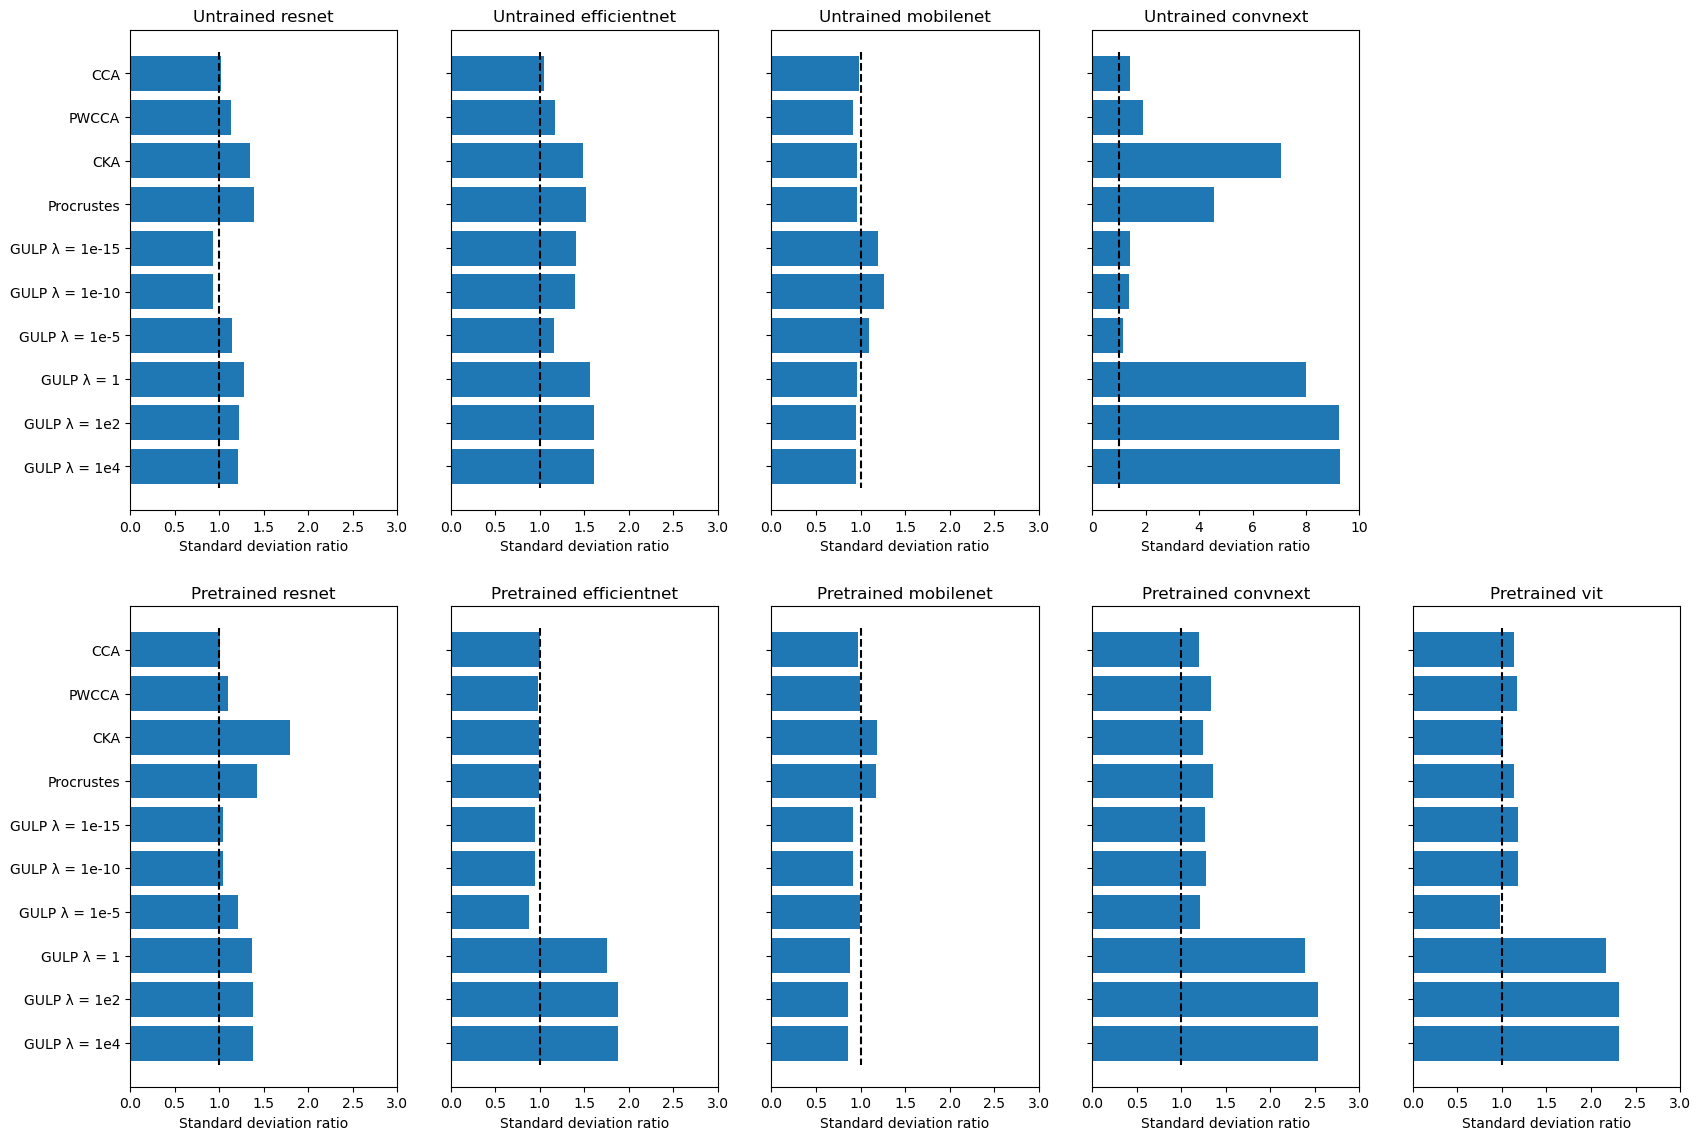

In [84]:
fig, axs = plt.subplots(2, num_classes, dpi=100, figsize=(20, 14))
fig.delaxes(axs[0, num_classes-1])

dist_inds = [3, 5, 0, 4, 12, 17, 22, 27, 29, 31]
num_dists = len(dist_inds)

labels = ['CCA', 'PWCCA', 'CKA', 'Procrustes', 'GULP λ = 1e-15', 'GULP λ = 1e-10', 'GULP λ = 1e-5', 'GULP λ = 1', 'GULP λ = 1e2', 'GULP λ = 1e4']
#labels = distnames[dist_inds]

for i in range(num_classes-1):
    ax = axs[0, i]
    ax.barh(np.arange(num_dists), 1/np.sqrt(untrained_variance_ratio[dist_inds, i]))
    ax.set_title(f"Untrained {class_names[i]}")
    ax.set_yticks(np.arange(num_dists))
    ax.vlines(1, -0.5, num_dists-0.5, linestyle="dashed", color="k")
    ax.set_xlabel("Standard deviation ratio")
    if i == 0:
        ax.set_yticklabels(labels)
    else:
        ax.set_yticklabels([])
    
    if i == num_classes-2:
        ax.set_xlim(0, 10)
    else:
        ax.set_xlim(0, 3)
    ax.invert_yaxis()

for i in range(num_classes):
    ax = axs[1, i]
    ax.barh(np.arange(num_dists), 1/np.sqrt(pretrained_variance_ratio[dist_inds, i]))
    ax.set_title(f"Pretrained {class_names[i]}")
    ax.set_yticks(np.arange(num_dists))
    if i == 0:
        ax.set_yticklabels(labels)
    else:
        ax.set_yticklabels([])
    ax.vlines(1, -0.5, num_dists-0.5, linestyle="dashed", color="k")
    ax.set_xlabel("Standard deviation ratio")
    ax.set_xlim(0, 3)
    ax.invert_yaxis()
plt.savefig("/home/gridsan/gstepaniants/geometric_toolkit_shared/paper_figures/imagenet_variance_networks.pdf")
plt.show()

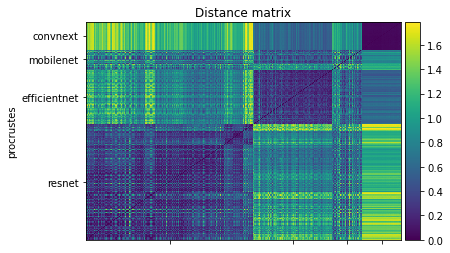

In [125]:
sorted_inds = np.array([], dtype=int)
spacings = []
for name in class_names[:-1]:
    class_inds = np.where(np.in1d(short_untrained_model_names, classes[name]))[0]
    spacings.append(len(sorted_inds) + len(class_inds)/2)
    sorted_inds = np.append(sorted_inds, class_inds)
spacings = np.array(spacings)

distname = "procrustes"

D = np.load(f'distances/{subset}/untrained/{distname}.npy')
D = np.reshape(D, [num_untrained_models, num_untrained_models])
D = symmetrize(D)
np.fill_diagonal(D, 0)

fig, ax = plt.subplots()
im = ax.pcolormesh(D[sorted_inds][:, sorted_inds])
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_title("Distance matrix")
ax.set_yticks(spacings + 0.5)
ax.set_yticklabels(class_names[:-1])
ax.set_ylabel(distname)
ax.set_xticks(spacings + 0.5)
if i == len(dist_inds)-1:
    ax.set_xticklabels(class_names[:-1], rotation=90)
    ax.set_xlabel("Untrained networks")
else:
    ax.set_xticklabels([])
plt.show()

In [124]:
D[sorted_inds[-40:]][:, sorted_inds[-40:]]

array([[0.        , 0.00655204, 0.00375101, ..., 0.01413709, 0.01507711,
        0.0049236 ],
       [0.00655204, 0.        , 0.00941566, ..., 0.02753697, 0.01888945,
        0.00883104],
       [0.00375101, 0.00941566, 0.        , ..., 0.01051785, 0.01877847,
        0.00523885],
       ...,
       [0.01413709, 0.02753697, 0.01051785, ..., 0.        , 0.04097267,
        0.02193373],
       [0.01507711, 0.01888945, 0.01877847, ..., 0.04097267, 0.        ,
        0.01179997],
       [0.0049236 , 0.00883104, 0.00523885, ..., 0.02193373, 0.01179997,
        0.        ]])

In [98]:
distnames[3]

'mean_sq_cca_e2e'

In [157]:
for name in model_names:
    rep1 = np.load(f"reps/train/3000_eval/{name}_pretrained_rep.npy")
    rep2 = np.load(f"reps/train/3000_eval/{name}_pretrained_rep.npy")
    
    print(name)
    print(np.linalg.norm(rep1 - rep2, 'fro'))

alexnet
2602.483483868723
convnext_base
584.6815859667527
convnext_large
525.1504597353755
convnext_small
655.3135358315823
convnext_tiny
529.8603578866197
densenet
0.0
efficientnet_b0
1326.2920441737638
efficientnet_b1
1506.6285752373306
efficientnet_b2
1469.401147155808
efficientnet_b3
1483.761603614128
efficientnet_b4
1975.888408345529
efficientnet_b5
1396.149797801927
efficientnet_b6
1276.8790418481399
efficientnet_b7
1279.473566429138
googlenet
1157.3065747570342
mnasnet
2177.6404332375937
mobilenet_v2
1775.242172611059
mobilenet_v3_large
2305.916183177415
mobilenet_v3_small
2096.4716985296586
regnet_x_16gf
0.0
regnet_x_1_6gf
0.0
regnet_x_32gf
0.0
regnet_x_3_2gf
0.0
regnet_x_400mf
0.0
regnet_x_800mf
0.0
regnet_x_8gf
0.0
regnet_y_16gf
0.0
regnet_y_1_6gf
0.0
regnet_y_32gf
0.0
regnet_y_3_2gf
0.0
regnet_y_400mf
0.0
regnet_y_800mf
0.0
regnet_y_8gf
0.0
resnet18
0.0
resnext50_32x4d
0.0
shufflenet
0.0
squeezenet
1551.7759339792476
vgg16
3019.966885899944
wide_resnet50_2
0.0


In [90]:
rep1 = np.load(f"reps/train/3000_eval/convnext_tiny_untrained1_rep.npy")
rep2 = np.load(f"reps/train/3000_eval/convnext_tiny_untrained10_rep.npy")

In [86]:
print(rep1)

[[-0.08965041 -0.27667263 -0.00974339 ... -0.00979318  0.6925205
   0.58881587]
 [-0.84911549  0.78497261  1.16666627 ... -0.62560892 -0.7831465
  -1.02190948]
 [-0.647156    0.4277066   0.59410322 ... -0.70666504  0.84190714
   0.3350015 ]
 ...
 [-0.5887298   0.00459948  0.47236416 ... -0.40184069 -0.36616939
  -0.18103008]
 [ 0.45045799 -0.20192674 -0.6677869  ... -0.07315086  0.47085622
   1.16314435]
 [ 0.30523953 -0.39418656 -0.31948954 ...  0.38865894  0.54397792
   0.47978818]]


In [91]:
np.linalg.norm(rep1 - rep2)

1381.4706978626618

In [227]:
model = torch.load(f"models/convnext_large.pth")
#model = torchvision.models.densenet161(pretrained=True)
model.train()
with torch.no_grad():
    x1 = model(train_dataset[0][0][None, :, :, :])

In [226]:
model = torch.load(f"models/convnext_small.pth")
#model = torchvision.models.densenet161(pretrained=True)
model.train()
with torch.no_grad():
    x2 = model(train_dataset[0][0][None, :, :, :])

In [228]:
x1 - x2

tensor([[ 4.7374e-01, -2.0637e-01,  5.5663e-02,  8.1466e-01, -3.0446e-01,
          3.0340e+00,  1.3927e+00, -3.3254e-01,  1.4509e+00,  4.0502e-01,
          9.7714e-01,  2.2582e+00, -3.1609e-01,  1.3997e+00, -1.0304e+00,
          1.8477e+00, -1.5606e-01, -1.2664e+00, -1.8065e+00,  5.8746e-02,
          1.3053e+00, -1.1147e+00,  1.8919e-01, -7.4978e-01, -3.3336e-01,
          1.8758e+00, -2.2289e-01,  5.4443e-02, -3.3961e-01, -5.5347e-01,
         -1.4699e+00,  2.3840e+00,  6.5197e-01, -9.0312e-01,  8.6047e-01,
          9.3636e-01,  1.3683e-02, -1.6196e+00,  1.3354e+00, -6.8549e-01,
         -6.2819e-01, -4.1218e-01, -6.9359e-02, -6.8927e-01, -1.3485e-01,
          1.9953e+00, -5.9152e-01,  1.2039e+00, -4.7939e-01,  1.9604e+00,
         -1.4795e-01,  5.8058e-01, -1.2530e-01,  3.9025e-01,  8.0911e-01,
         -2.8461e-01,  6.9906e-01,  6.8587e-01, -4.8358e-01,  1.8987e-01,
         -2.6560e-01,  1.3281e+00,  4.9262e-01, -2.6985e-01,  5.6090e-01,
          1.8573e+00,  8.2505e-01,  1.

In [116]:
x2

tensor([[-2.8735e-15,  8.1964e-16, -3.9390e-15,  1.7071e-15,  3.7733e-15,
          6.7839e-16, -8.2630e-16,  8.1196e-16,  6.4901e-16,  2.9510e-15,
         -2.3678e-15,  1.2992e-15, -3.3810e-15,  1.3532e-15,  3.3994e-15,
          2.1487e-15, -1.5925e-15, -4.2538e-15, -1.0235e-15, -8.0758e-16,
          3.2963e-15,  5.2198e-15,  4.5665e-15,  3.1983e-15, -2.8780e-15,
          5.0831e-15,  2.8139e-15,  2.5241e-15,  4.6776e-15, -2.7967e-15,
          2.4858e-17,  8.1997e-16,  1.0532e-15, -1.3238e-15,  3.1790e-15,
          3.2280e-15, -2.5581e-15, -2.9171e-15,  5.4638e-15, -2.4022e-15,
          1.7772e-15,  2.0886e-15, -2.5384e-16, -1.7618e-15, -6.4348e-15,
          8.3312e-16, -3.5356e-15, -5.3797e-15,  2.3780e-15, -4.8870e-16,
         -1.3391e-15, -3.6105e-15,  1.7216e-15, -3.0957e-15,  3.2910e-15,
         -3.0394e-15,  1.6750e-15, -1.0556e-15,  1.0041e-14, -3.3766e-15,
          8.8953e-16,  2.5786e-15, -6.9218e-15, -5.4316e-15,  1.8600e-15,
         -1.0377e-15,  4.8068e-15, -2.

In [36]:
for name in model_names:
    rep1 = np.load(f"reps/train/3000_eval/{name}_rep.npy")
    rep2 = np.load(f"reps/train/3000_eval2/{name}_rep.npy")
    
    print(name)
    print(np.linalg.norm(rep1 - rep2, 'fro'))

alexnet
0.0
convnext_base
0.0
convnext_large
0.0
convnext_small
0.0
convnext_tiny
0.0
densenet
0.0
efficientnet_b0
0.0
efficientnet_b1
0.0
efficientnet_b2
0.0
efficientnet_b3
0.0
efficientnet_b4
0.0
efficientnet_b5
0.0
efficientnet_b6
0.0
efficientnet_b7
0.0
googlenet
0.0
inception
0.0
mnasnet
0.0
mobilenet_v2
0.0
mobilenet_v3_large
0.0
mobilenet_v3_small
0.0
regnet_x_16gf
0.0
regnet_x_1_6gf
0.0
regnet_x_32gf
0.0
regnet_x_3_2gf
0.0
regnet_x_400mf
0.0
regnet_x_800mf
0.0
regnet_x_8gf
0.0
regnet_y_16gf
0.0
regnet_y_1_6gf
0.0
regnet_y_32gf
0.0
regnet_y_3_2gf
0.0
regnet_y_400mf
0.0
regnet_y_800mf
0.0
regnet_y_8gf
0.0
resnet18
0.0
resnext50_32x4d
0.0
shufflenet
0.0
squeezenet
0.0
vgg16
0.0


FileNotFoundError: [Errno 2] No such file or directory: 'reps/train/3000_eval/vit_b_16_rep.npy'

In [150]:
print(dir(torchvision.models))

['AlexNet', 'DenseNet', 'GoogLeNet', 'GoogLeNetOutputs', 'Inception3', 'InceptionOutputs', 'MNASNet', 'MobileNetV2', 'MobileNetV3', 'ResNet', 'ShuffleNetV2', 'SqueezeNet', 'VGG', '_GoogLeNetOutputs', '_InceptionOutputs', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_utils', 'alexnet', 'densenet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'detection', 'googlenet', 'inception', 'inception_v3', 'mnasnet', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'mobilenetv2', 'mobilenetv3', 'quantization', 'resnet', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext50_32x4d', 'segmentation', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'shufflenetv2', 'squeezenet', 'squeezenet1_0', 'squeezenet1_1', 'utils', 'vgg', 'vgg11', 'vgg11_bn', 'vgg13', '

In [166]:
for name in untrained_model_names:
    for i in range(10):
        for j in range(i+1, 10):
            rep1 = np.load(f"reps/val/3000_eval/{name}_untrained{i+1}_rep.npy")
            rep2 = np.load(f"reps/val/3000_eval/{name}_untrained{j+1}_rep.npy")
            
            if np.linalg.norm(rep1 - rep2, 'fro') == 0:
                print(f"{name} ({i+1}, {j+1}): BAD")

0, 0
0, 1
0, 2
0, 3
1, 0
1, 1
1, 2
1, 3
2, 0
2, 1
2, 2
2, 3


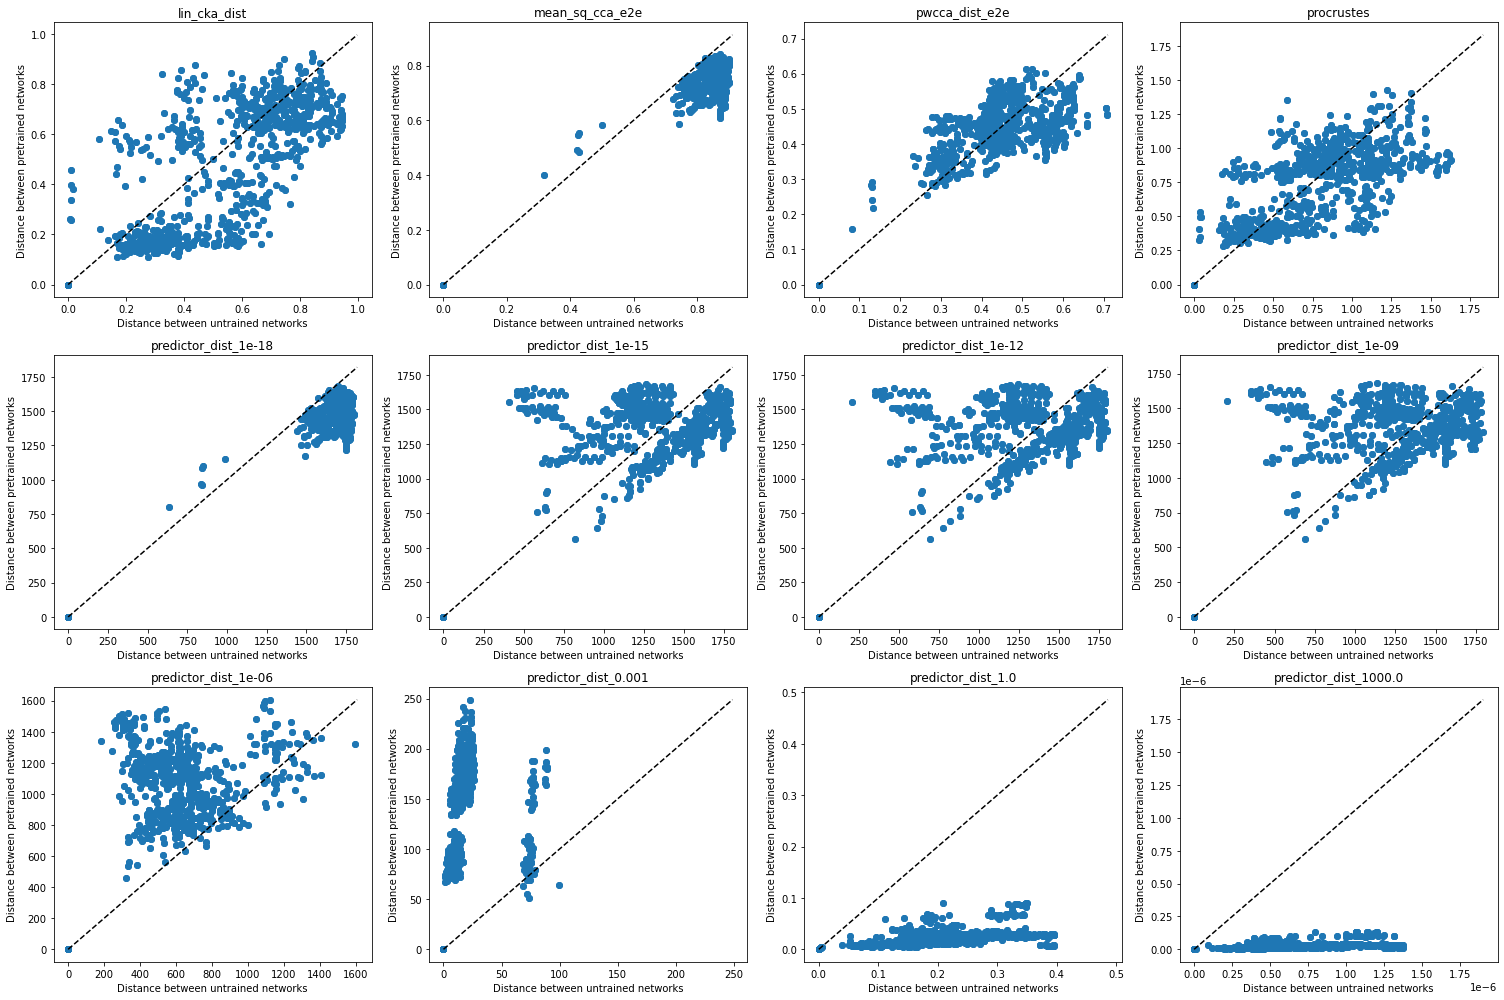

In [74]:
shared_model_names = np.sort(np.intersect1d(short_pretrained_model_names, short_untrained_model_names))
sub_inds_untrained = np.in1d(short_untrained_model_names, shared_model_names)
sub_inds_pretrained = np.in1d(short_pretrained_model_names, shared_model_names)

dist_inds = [0, 3, 5, 4, 9, 12, 15, 18, 21, 24, 27, 30]

w = 4
h = 3
fig, axs = plt.subplots(h, w, figsize=(21, 14))
for i in range(len(dist_inds)):
    D_untrained = np.load(f'distances/{subset}/untrained/{distnames[dist_inds[i]]}.npy')
    D_untrained = np.reshape(D_untrained, [num_untrained_models, num_untrained_models])
    D_untrained = symmetrize(D_untrained)
    np.fill_diagonal(D_untrained, 0)
    
    xs = []
    for j in range(10):
        xs.append(D_untrained[np.arange(j, 390, 10), :][:, np.arange(j, 390, 10)].flatten())
    xs = np.vstack(xs)
    
    D_pretrained = np.load(f'distances/{subset}/pretrained/{distnames[dist_inds[i]]}.npy')
    D_pretrained = np.reshape(D_pretrained, [num_pretrained_models, num_pretrained_models])
    D_pretrained = symmetrize(D_pretrained)
    np.fill_diagonal(D_pretrained, 0)
    D_pretrained = D_pretrained[sub_inds_pretrained][:, sub_inds_pretrained]
    y = D_pretrained.flatten()
    
    maxval = max(np.max(xs), np.max(y))
    
    print(f"{i // w}, {i % w}")
    ax = axs[i // w, i % w]
    ax.scatter(np.mean(xs, axis=0), y)
    ax.plot([0, maxval], [0, maxval], linestyle="dashed", color='k')
    ax.set_xlabel("Distance between untrained networks")
    ax.set_ylabel("Distance between pretrained networks")
    ax.set_title(f"{distnames[dist_inds[i]]}")
plt.tight_layout()
plt.show()

In [57]:
w % len(dist_inds)-1

3

In [62]:
(len(dist_inds)-1) % w

3

In [86]:
untrained_model_names # 39 (removed ViT and GoogleNet)

array(['alexnet_untrained1', 'alexnet_untrained10', 'alexnet_untrained2',
       'alexnet_untrained3', 'alexnet_untrained4', 'alexnet_untrained5',
       'alexnet_untrained6', 'alexnet_untrained7', 'alexnet_untrained8',
       'alexnet_untrained9', 'convnext_base_untrained1',
       'convnext_base_untrained10', 'convnext_base_untrained2',
       'convnext_base_untrained3', 'convnext_base_untrained4',
       'convnext_base_untrained5', 'convnext_base_untrained6',
       'convnext_base_untrained7', 'convnext_base_untrained8',
       'convnext_base_untrained9', 'convnext_large_untrained1',
       'convnext_large_untrained10', 'convnext_large_untrained2',
       'convnext_large_untrained3', 'convnext_large_untrained4',
       'convnext_large_untrained5', 'convnext_large_untrained6',
       'convnext_large_untrained7', 'convnext_large_untrained8',
       'convnext_large_untrained9', 'convnext_small_untrained1',
       'convnext_small_untrained10', 'convnext_small_untrained2',
       'convne

In [98]:
np.hstack([classes[name] for name in class_names])

array(['regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf',
       'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf',
       'regnet_x_8gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf',
       'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf',
       'regnet_y_8gf', 'resnet18', 'resnext50_32x4d', 'wide_resnet50_2',
       'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2',
       'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5',
       'efficientnet_b6', 'efficientnet_b7', 'mobilenet_v2',
       'mobilenet_v3_large', 'mobilenet_v3_small', 'convnext_base',
       'convnext_large', 'convnext_small', 'convnext_tiny', 'vit_b_16',
       'vit_b_32', 'vit_l_16', 'vit_l_32'], dtype='<U18')